# Finding discords of any length in a time series

This tutorial explains the MERLIN algorithm proposed in [MERLIN](https://www.cs.ucr.edu/~eamonn/MERLIN_Long_version_for_website.pdf). 

You can find the support webpage here: [MERLIN: SUPPORT](https://sites.google.com/view/merlin-find-anomalies).

The algorithm provides the discords of arbitrary length in time series.

## import libraries

In [51]:
%matplotlib inline

import pandas as pd
import stumpy
import numpy as np
import matplotlib.pyplot as plt
import math

plt.style.use('stumpy.mplstyle')

## import toy data set: noisy sine wave

In [52]:
from scipy.io import loadmat

# data set is available at: 
# https://drive.google.com/file/d/1cDkZVKYse_E0_fGZqTRQZrrMBRFrR2Mv/view

data = loadmat("MERLIN_datasets\\NoisySine.mat") 
ts = data['T'].reshape(-1,)

## Visualizing data

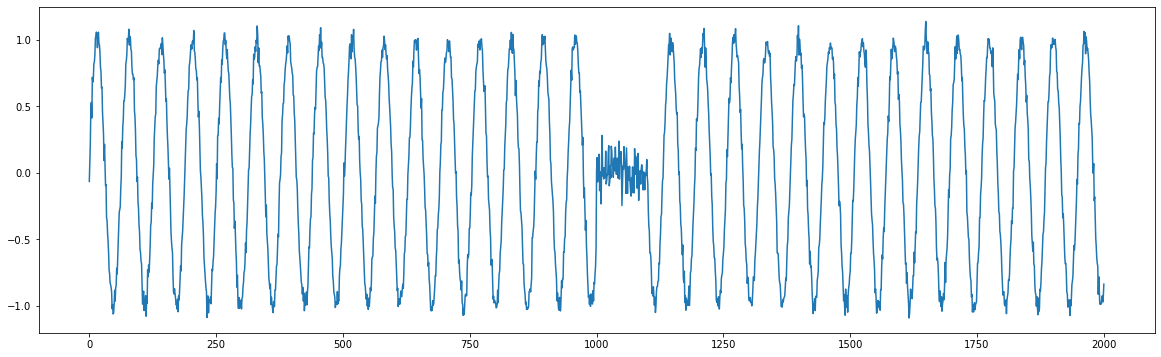

In [53]:
plt.plot(ts)
plt.show()

As depicted in the figure above, there is an anomaly in the sequence

## implemeting MERLIN algorithm (In contrast to paper, we consider STUMPY exclusion to compare the results with MP)

### part I: DRAG algorithm 

DRAG algorithm is a name used by the authors to refer to the algorithm proposed in [](). The DRAG aglorithm tries to find a set of discords for a user-defined r (range of discord: the threshold. A subsequence is discord if its distance to its NN is not less than r.

In [54]:
def candidate_selection_algorithm(
    T, 
    m, 
    r,
    sep = None
):
    """
    For a time series T, the algorithm finds a set of discords whose distance with their NN is more than r. 
    
    Parameters
    ---------
    T: ndarray
        the time series for which we try to find the discords
    
    m: int
        the length of the subsequence to consider in discovering the discords
    
    r: float
        the maximum distance allowed for non-discord subsquence to its NN subsequence 
        (threshold for discords' distance)
    
    
    output
    --------
    C: set
        a set of discords
    
    """
    z_normalize = True
    
    #create empty set
    C = set()
    
    if sep is None:
        sep = math.ceil(m/4) + 1
    
    
    
    #scan all subsequences
    for i in range(0,len(T)-m):
        is_candidate = True
        T_i = T[i:(i+m)]
        T_i = stumpy.core.z_norm(T_i)
        
        for j in C:
            if abs(i-j)>=sep: #non-trival match test
                T_j = T[j:(j+m)]
                T_j = stumpy.core.z_norm(T_j)
                
                dist = np.linalg.norm(T_i-T_j)
                if dist < r:
                    is_candidate = False
                    break
        
        if is_candidate:
            C.add(i)
        else:
            C.remove(j)

            
    return C

In [55]:
T = ts[:]
m = 512 #one day as the length of subsequence
r = 10.27

C = candidate_selection_algorithm(T, m, r)
print('set C is: \n', C)

set C is: 
 {584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 735, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 771, 780, 781, 792, 793, 794, 795, 796, 797, 798, 799, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 824, 825, 826, 827, 828, 829, 830, 831, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 864, 865, 885, 886, 887, 896, 906, 907, 908, 909, 91

In [56]:
def discords_refinement_algorithm(
    T, 
    m, 
    r, 
    C,
    sep=None
):
    """
    For a time series T, the algorithm refines a set of discords by removing the false positives,
    i.e. the subsequences whose distance from their NN is more than r. 
    
    Parameters
    ---------
    T: ndarray
        the time series for which we try to find the discords
    
    m: int
        the length of the subsequence to consider in discovering the discords
    
    r: float
        the maximum distance allowed for non-discord subsquence to its NN subsequence 
        (threshold for discords' distance)
    
    C: set
        the set of indices of initially-discovered discored
    
    
    output
    --------
    discords: dataframe
        a dataframe where each row corresponds to a discovered discord 
        The columns are: ['Discord index', 'Discord NN index', 'NN distance']
        
    """
    
    if sep is None:
        sep = math.ceil(m/4) + 1
        
    C_list = list(C)
    
    D=np.empty(shape=(len(C_list),3)) #[discord index, discord NN index, NN dist]
    D[:,0] = C_list
    D[:,1] = -1
    D[:,2] = float('inf')
    
    _to_be_removed_idx = []
    
    
    for i in range(0, len(T)-m):
        if len(C_list)==0:
            print('The set C is empty. No discord discovered!')
            break
        
        is_discord = True
        T_i = stumpy.core.z_norm(T[i:(i+m)])
        
        for j_idx, j in enumerate(C_list):
            if j_idx not in _to_be_removed_idx:
                if abs(i-j)>=sep:
                    T_j = stumpy.core.z_norm(T[j:(j+m)])

                    dist = np.linalg.norm(T_i-T_j)
                    if dist<r:
                        _to_be_removed_idx.append(j_idx)
                    else:
                        if dist<D[j_idx,2]:
                            D[j_idx,2] = dist
                            D[j_idx,1] = i
    
    D_pruned = np.delete(D, _to_be_removed_idx, axis=0)
    discords = pd.DataFrame(data = D_pruned, 
                  columns = ['Discord index', 'Discord NN index', 'NN distance'])
        
    return discords

In [57]:
discords = discords_refinement_algorithm(T, m, r, C)
discords

Discord index  Discord NN index  NN distance
0           592.0             152.0    10.270556
1           593.0             153.0    10.274022
2           594.0             154.0    10.273065
3           621.0             181.0    10.270276
4           622.0             182.0    10.278849
5           623.0             183.0    10.284921
6           624.0             184.0    10.285366
7           625.0             185.0    10.285081
8           626.0             186.0    10.279453
9           627.0             187.0    10.272296
10          652.0             212.0    10.272322
11          653.0             213.0    10.281739
12          654.0             214.0    10.290871
13          655.0             215.0    10.294041
14          656.0             216.0    10.291022
15          657.0             217.0    10.285847
16          658.0             218.0    10.279481
17          659.0             219.0    10.274710
18          683.0             243.0    10.270082
19          684.0             244.0    10.282060
20          685.0             245.0    10.289942
21          686.0             246.0    10.297224
22          687.0             247.0    10.297374
23          688.0             248.0    10.295380
24          689.0             249.0    10.289319
25          690.0             250.0    10.283870
26          691.0             251.0    10.272261
27          715.0             275.0    10.275912
28          716.0             276.0    10.287245
29          717.0             277.0    10.295350
30          718.0             278.0    10.301397
31          719.0            1096.0    10.301242
32          720.0            1097.0    10.277130
33          749.0            1126.0    10.273560
34          750.0            1127.0    10.276716
35          751.0            1128.0    10.272921
36          780.0            1157.0    10.274233
37          781.0            1158.0    10.271980
38          906.0            1283.0    10.271813
39          907.0            1284.0    10.270657
40          908.0            1285.0    10.270418

In [58]:
discords_sorted = discords.sort_values(by ='NN distance', ascending=False, ignore_index=True)
discords_sorted

Discord index  Discord NN index  NN distance
0           718.0             278.0    10.301397
1           719.0            1096.0    10.301242
2           687.0             247.0    10.297374
3           686.0             246.0    10.297224
4           688.0             248.0    10.295380
5           717.0             277.0    10.295350
6           655.0             215.0    10.294041
7           656.0             216.0    10.291022
8           654.0             214.0    10.290871
9           685.0             245.0    10.289942
10          689.0             249.0    10.289319
11          716.0             276.0    10.287245
12          657.0             217.0    10.285847
13          624.0             184.0    10.285366
14          625.0             185.0    10.285081
15          623.0             183.0    10.284921
16          690.0             250.0    10.283870
17          684.0             244.0    10.282060
18          653.0             213.0    10.281739
19          658.0             218.0    10.279481
20          626.0             186.0    10.279453
21          622.0             182.0    10.278849
22          720.0            1097.0    10.277130
23          750.0            1127.0    10.276716
24          715.0             275.0    10.275912
25          659.0             219.0    10.274710
26          780.0            1157.0    10.274233
27          593.0             153.0    10.274022
28          749.0            1126.0    10.273560
29          594.0             154.0    10.273065
30          751.0            1128.0    10.272921
31          652.0             212.0    10.272322
32          627.0             187.0    10.272296
33          691.0             251.0    10.272261
34          781.0            1158.0    10.271980
35          906.0            1283.0    10.271813
36          907.0            1284.0    10.270657
37          592.0             152.0    10.270556
38          908.0            1285.0    10.270418
39          621.0             181.0    10.270276
40          683.0             243.0    10.270082

#### PLOT the Top Discord

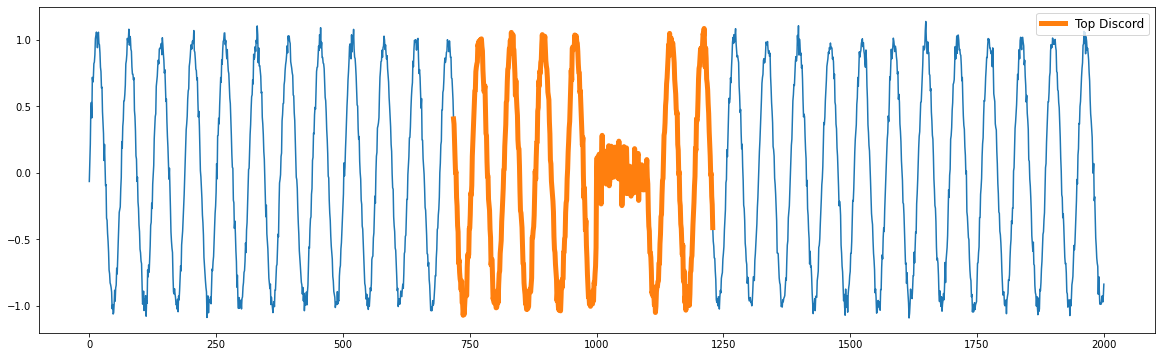

In [59]:
Top_Discord = discords_sorted.iloc[0,:]
Top_Discord_idx = int(Top_Discord[0])

plt.plot(ts)
plt.plot(np.arange(Top_Discord_idx,Top_Discord_idx+m),ts[Top_Discord_idx:Top_Discord_idx+m], lw=5, label='Top Discord')
plt.legend(fontsize=12)
plt.show()

In [60]:
#reproduce result of paper
discords_idx_sorted = discords.sort_values(by ='Discord index', ascending=True)
discords_idx_sorted

Discord index  Discord NN index  NN distance
0           592.0             152.0    10.270556
1           593.0             153.0    10.274022
2           594.0             154.0    10.273065
3           621.0             181.0    10.270276
4           622.0             182.0    10.278849
5           623.0             183.0    10.284921
6           624.0             184.0    10.285366
7           625.0             185.0    10.285081
8           626.0             186.0    10.279453
9           627.0             187.0    10.272296
10          652.0             212.0    10.272322
11          653.0             213.0    10.281739
12          654.0             214.0    10.290871
13          655.0             215.0    10.294041
14          656.0             216.0    10.291022
15          657.0             217.0    10.285847
16          658.0             218.0    10.279481
17          659.0             219.0    10.274710
18          683.0             243.0    10.270082
19          684.0             244.0    10.282060
20          685.0             245.0    10.289942
21          686.0             246.0    10.297224
22          687.0             247.0    10.297374
23          688.0             248.0    10.295380
24          689.0             249.0    10.289319
25          690.0             250.0    10.283870
26          691.0             251.0    10.272261
27          715.0             275.0    10.275912
28          716.0             276.0    10.287245
29          717.0             277.0    10.295350
30          718.0             278.0    10.301397
31          719.0            1096.0    10.301242
32          720.0            1097.0    10.277130
33          749.0            1126.0    10.273560
34          750.0            1127.0    10.276716
35          751.0            1128.0    10.272921
36          780.0            1157.0    10.274233
37          781.0            1158.0    10.271980
38          906.0            1283.0    10.271813
39          907.0            1284.0    10.270657
40          908.0            1285.0    10.270418

### DRAG algorithm:

Let's combine the first two algorithm to only return the first discorc

In [61]:
def DRAG(T,m,r, separation_fraction=None):
    """
    For a time series T, the algorithm finds a set of discords whose distance with their NN is more than r. 
    
    Parameters
    ---------
    T: ndarray
        the time series for which we try to find the discords
    
    m: int
        the length of the subsequence to consider in discovering the discords
    
    r: float
        the maximum distance allowed for non-discord subsquence to its NN subsequence 
        (threshold for discords' distance)
    
    
    output
    --------
    idx: index of top discord
    idx_NN: index of NN of top discord
    dist: dist between top discor and its NN  
    """
    
    #initializing output
    idx = -1; idx_NN = -1; dist = -1
    
    if separation_fraction is None:
        separation_fraction = 1/4
    
    sep = math.ceil(m*separation_fraction) + 1
    
    C = candidate_selection_algorithm(T, m, r, sep) 
    
    if len(C)>0:
        discords = discords_refinement_algorithm(T, m, r, C, sep)
        
        if len(discords['NN distance'])>0:
            top_discord = discords['NN distance'].argmax()
            idx = int(discords.iloc[top_discord, 0])
            idx_NN = int(discords.iloc[top_discord, 1])
            dist = discords.iloc[top_discord, 2] 

    return idx, idx_NN, dist

In [62]:
TopDiscord_idx, TopDiscord_idx_NN, TopDiscord_dist = DRAG(T,m,r) 

print("TopDiscord_idx: ", TopDiscord_idx)
print("TopDiscord_idx_NN: ", TopDiscord_idx_NN)
print("TopDiscord_dist: ", TopDiscord_dist)

TopDiscord_idx:  718
TopDiscord_idx_NN:  278
TopDiscord_dist:  10.301397123539063


In [63]:
#let's use STUMPY matrix profile:
mp = stumpy.stump(T, m)
discord_idx_MP = np.argmax(mp[:,0])
discord_NN_idx_MP = mp[discord_idx_MP,1]
discord_dist_MP = mp[discord_idx_MP,0]

print("discord_idx via matix profile: ", discord_idx_MP)
print("discord_NN_idx via matix profile: ", discord_NN_idx_MP)
print("discord_dist via matix profile: ", discord_dist_MP)

discord_idx via matix profile:  718
discord_NN_idx via matix profile:  278
discord_dist via matix profile:  10.30139712353895


### part II: MERLIN algorithm 

After the implementation of DRAG algorithm, we are at the position where we can start to implement MERLIN algorithm:

In [64]:
def MERLIN(T, MinL, MaxL, separation_fraction=None):
    """
    For a time series T, the algorithm finds discords with length between MinL and MaxL. 
    
    Parameters
    ---------
    T: ndarray
        the time series for which we try to find the discords
    
    MinL: int
        subsequence length lower bound
    
    MaxL: int
        subsequence length upper bound
    
    separation_fraction: to exclude indices; If None, set it to 1/4 of subsequence length 
    
    output
    --------
    Discords : ndarray
        a two dimentional array where the axis 0 contains different discords and axis 1 has the information 
        of discord: 
        first column is the starting index of the discord subsequence
        second column is the length of the discord
        third column is the NN index
        fourth column is the distance of the discord to its NN
    
    """
    Discords = np.empty(shape = (0, 4), dtype='object') #Alternatively: Create np array with nrows=MaxL-MinL+1
    
    
    # Calculate the first discord of length MinL
    print('Stage#1: Calculating the first discord...')
    m = MinL
    r = 2 * (m ** 0.5)
    dist = -1
    while dist < 0:
        idx, idx_NN, dist = DRAG(T, m, r, separation_fraction)
        r = r / 2
    
    new_discord = [idx, m, idx_NN, dist]
    Discords = np.vstack((Discords, new_discord))
    print('Discords after finding the first one: \n', new_discord)
    
    
    # Calculate next four discords (for the next four subsequent length)
    print('Stage#2: Calculating the next four discords...')
    dist_old = dist # we need the dist of the previous discord to modify r
    for m in range(MinL+1,MinL+5): 
        r = 0.99 * dist_old 
        
        dist = -1
        while dist < 0:
            idx, idx_NN, dist = DRAG(T, m, r, separation_fraction)
            r = 0.99 * r
            
        new_discord = [idx, m, idx_NN, dist]
        Discords = np.vstack((Discords, new_discord))
        dist_old = dist
        print('>>> Discords after finding the next four discords: ', new_discord)
    
    
    # Calculate the remaining discords
    print('Stage#3: Calculating the remaining discords...')
    for m in range(MinL+5,MaxL+1): #what if MinL+5 > MaxL+1 ? (we need to consider such scenarios)
        mu_dist = np.mean(Discords[-5:, 3]) # calculating the mean of distance of the last 5 discovered discords 
        std_dist = np.std(Discords[-5:, 3]) # calculating the std of distance of the last 5 discovered discords
        
        r = mu_dist - 2 * std_dist
        
        dist = -1
        while dist < 0:
            idx, idx_NN, dist = DRAG(T, m, r, separation_fraction)
            r = r - std_dist
        
        new_discord = [idx, m, idx_NN, dist]
        Discords = np.vstack((Discords, new_discord))
        print('>>> new discord: ', new_discord)
    
    
    return Discords

## Let's use MERLIN on TAXI data (Fig. 11)

In [65]:
#read data
df_taxi = pd.read_csv("MERLIN_datasets\\NAB_NYC_TAXI\\data\\realKnownCause\\nyc_taxi.csv") 
df_taxi = df_taxi.set_index(['timestamp'])

#select the range of dates considered in the paper
data =  df_taxi.loc['2014-10-01 00:00:00' : '2014-12-15 23:00:00']
data

value
timestamp                 
2014-10-01 00:00:00  12751
2014-10-01 00:30:00   8767
2014-10-01 01:00:00   7005
2014-10-01 01:30:00   5257
2014-10-01 02:00:00   4189
...                    ...
2014-12-15 21:00:00  21393
2014-12-15 21:30:00  21577
2014-12-15 22:00:00  21019
2014-12-15 22:30:00  18908
2014-12-15 23:00:00  17370

[3647 rows x 1 columns]

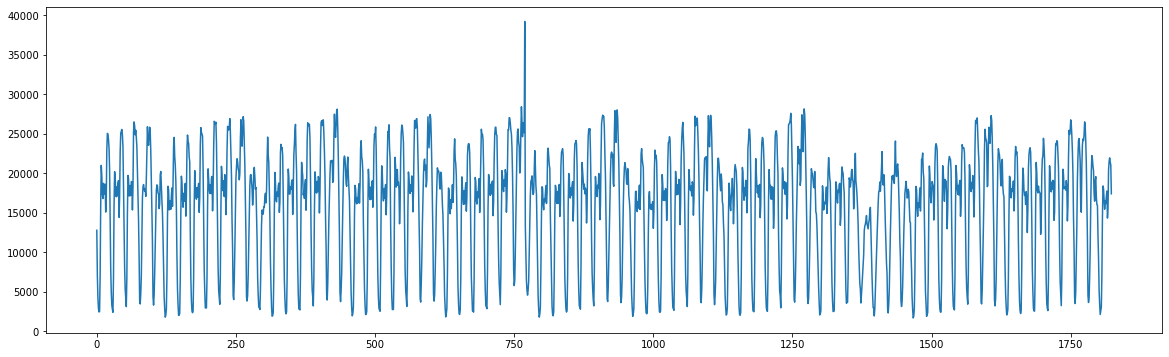

In [66]:
ts = np.reshape(data.to_numpy(),newshape=(-1,))
#let's consider only the data at each hour (not the half hours)
ts = [val for i,val in enumerate(ts) if i % 2 == 0]
ts = np.asarray(ts)

#to use it later in  MATLAB 
np.savetxt("taxi_to_reproduce_paper.csv.csv", ts, delimiter=",")

#plottting
plt.plot(ts)
plt.show()

In [67]:
np.set_printoptions(suppress=True)
Discords = MERLIN(ts, 5, 96)

Stage#1: Calculating the first discord...
Discords after finding the first one: 
 [1690, 5, 1120, 1.3642079150627304]
Stage#2: Calculating the next four discords...
>>> Discords after finding the next four discords:  [1522, 6, 1100, 1.4064712539239808]
>>> Discords after finding the next four discords:  [537, 7, 1689, 1.62928107746437]
>>> Discords after finding the next four discords:  [1380, 8, 443, 1.746810126819628]
>>> Discords after finding the next four discords:  [762, 9, 1328, 2.0634858945465493]
Stage#3: Calculating the remaining discords...
>>> new discord:  [761, 10, 1327, 2.1247537919540944]
>>> new discord:  [760, 11, 1381, 2.629462897528745]
>>> new discord:  [759, 12, 1380, 2.746225055671875]
>>> new discord:  [758, 13, 1379, 2.9819137944892202]
>>> new discord:  [757, 14, 1261, 3.5977491081910626]
>>> new discord:  [756, 15, 1260, 3.7262163688495025]
>>> new discord:  [755, 16, 1259, 3.8542112273477858]
>>> new discord:  [754, 17, 1258, 3.773480491623614]
>>> new disco

In [68]:
#printing Discords:
Discords

array([[1690.0, 5.0, 1120.0, 1.3642079150627304],
       [1522.0, 6.0, 1100.0, 1.4064712539239808],
       [537.0, 7.0, 1689.0, 1.62928107746437],
       [1380.0, 8.0, 443.0, 1.746810126819628],
       [762.0, 9.0, 1328.0, 2.0634858945465493],
       [761.0, 10.0, 1327.0, 2.1247537919540944],
       [760.0, 11.0, 1381.0, 2.629462897528745],
       [759.0, 12.0, 1380.0, 2.746225055671875],
       [758.0, 13.0, 1379.0, 2.9819137944892202],
       [757.0, 14.0, 1261.0, 3.5977491081910626],
       [756.0, 15.0, 1260.0, 3.7262163688495025],
       [755.0, 16.0, 1259.0, 3.8542112273477858],
       [754.0, 17.0, 1258.0, 3.773480491623614],
       [753.0, 18.0, 1257.0, 3.4080630531206326],
       [753.0, 19.0, 1593.0, 3.173663379789231],
       [752.0, 20.0, 1592.0, 2.8985780733789492],
       [752.0, 21.0, 1592.0, 2.670509417879137],
       [769.0, 22.0, 97.0, 2.513778263195744],
       [769.0, 23.0, 97.0, 2.566742363683388],
       [769.0, 24.0, 97.0, 2.5845448370266633],
       [768.0, 25.0

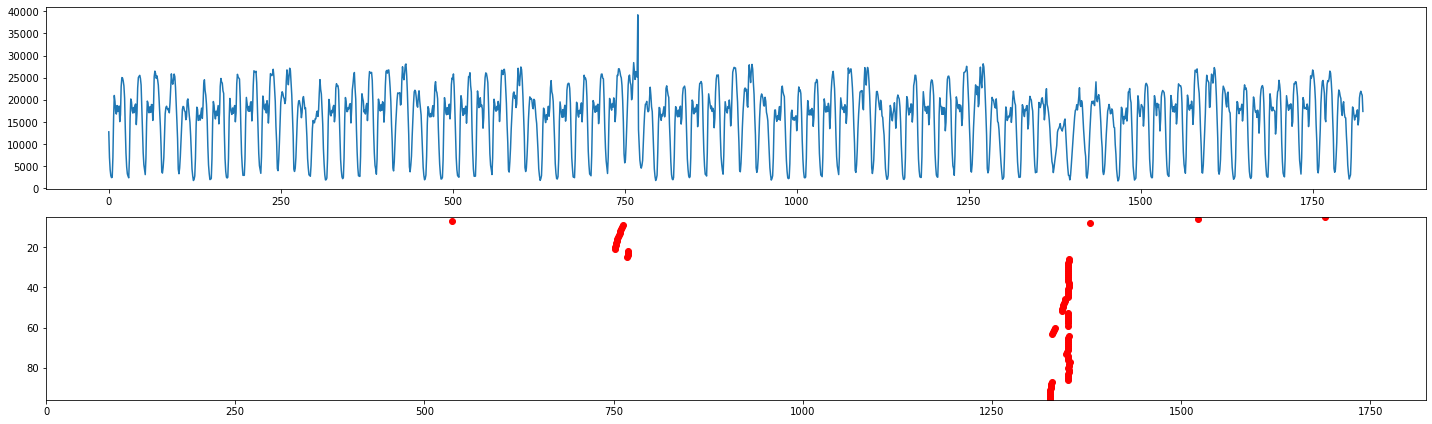

In [69]:
n_ts = len(ts)

fig, ax = plt.subplots(nrows=2, ncols=1)
ax[0].plot(ts)

ax[1].set_xlim(left=0, right=n_ts-1) 
ax[1].set_ylim(bottom=96, top=5) 
for item in Discords:
    ax[1].scatter(x=int(item[0]), y=int(item[1]),c='r')

fig.tight_layout()
plt.show()

There are a few discords that is not "clearly" illustrated in the figure 11 of the paper. However, if we zoom in, we will notice that these points are shown (but with lower color value.) These points might be false positives as discussed by paper in some sections.

### Comparing with MATLAB (by the author)

The figure obtained by MATLAB code shown below. Some points are highlighted. These are the ones that are vaguely illustrated in Fig. 11.

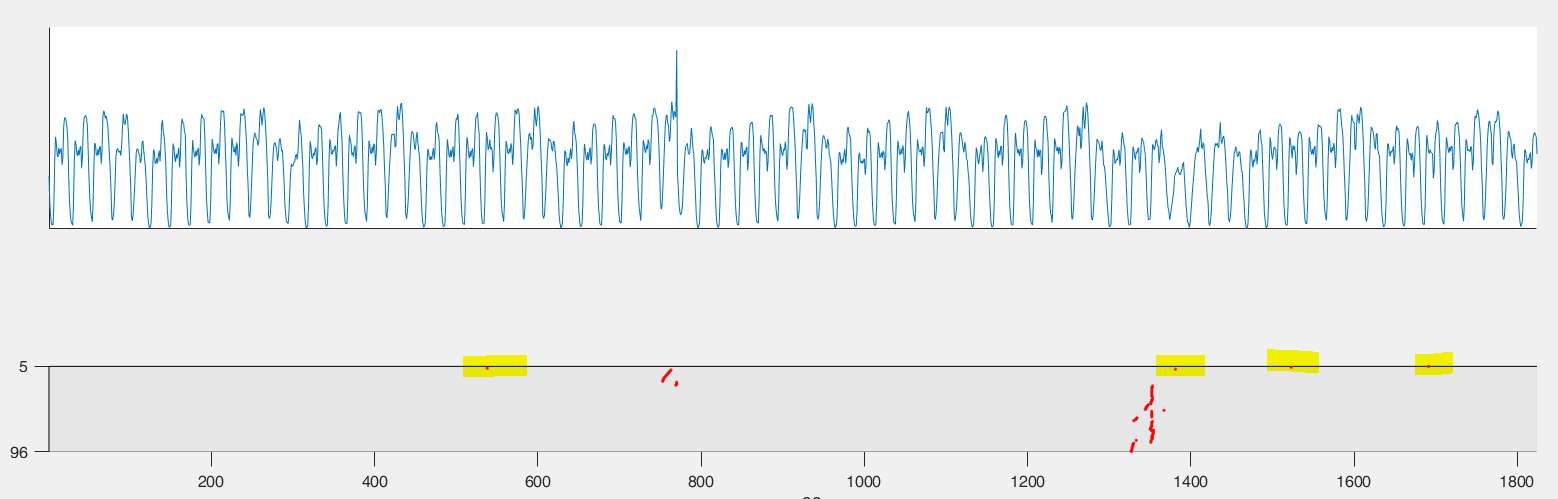



### Comparing values obainted by Python / MATLAB

In [70]:
#two files: Taxi_MATLAB_results.csv (MERLIN3), Taxi_MATLAB_results_r99percent.csv (MERLIN3 but with r=r*0.99)
Discords_by_MATLAB = pd.read_csv("MERLIN_datasets\\taxi_results_by_MATLAB\\Taxi_MATLAB_results.csv", header=None).to_numpy()


for col in range(4):
    modification_val = 0
    if ((col==0) or (col==2)):
        modification_val = 1
    
    Discords_MATLAB = Discords_by_MATLAB[:,col] #by MATLAB code
    Discords_Python = Discords[:,col] + modification_val #by Python code (but with MATLAB indexing)
    
    diff = np.abs(Discords_MATLAB - Discords_Python)
    print(f'> differece at col={col} is: \n {diff}')

> differece at col=0 is: 
 [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 24.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 5.0 0.0 3.0 2.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 19.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0]
> differece at col=1 is: 
 [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0]
> differece at col=2 is: 
 [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
 0.0 0.0 0.0 0.0 0.0 

### plot discords that are different in MATLAB and Python

mask:  [47 68 70 71 79]
> Discords_by_MATLAB_only: 
 [[1367.           52.          286.            3.68959178]
 [1354.           73.          969.            5.44054626]
 [1354.           75.           10.            5.5274995 ]
 [1354.           76.           10.            5.5868335 ]
 [1333.           84.          948.            5.55797485]]
>  Discords_by_Python_only: 
 [[1342.0 52.0 240.0 4.290034033714779]
 [1348.0 73.0 963.0 5.351572212173198]
 [1350.0 75.0 1301.0 5.411437945118361]
 [1351.0 76.0 1302.0 5.497467824497779]
 [1351.0 84.0 1519.0 5.963234981527579]]
n_discord:  5


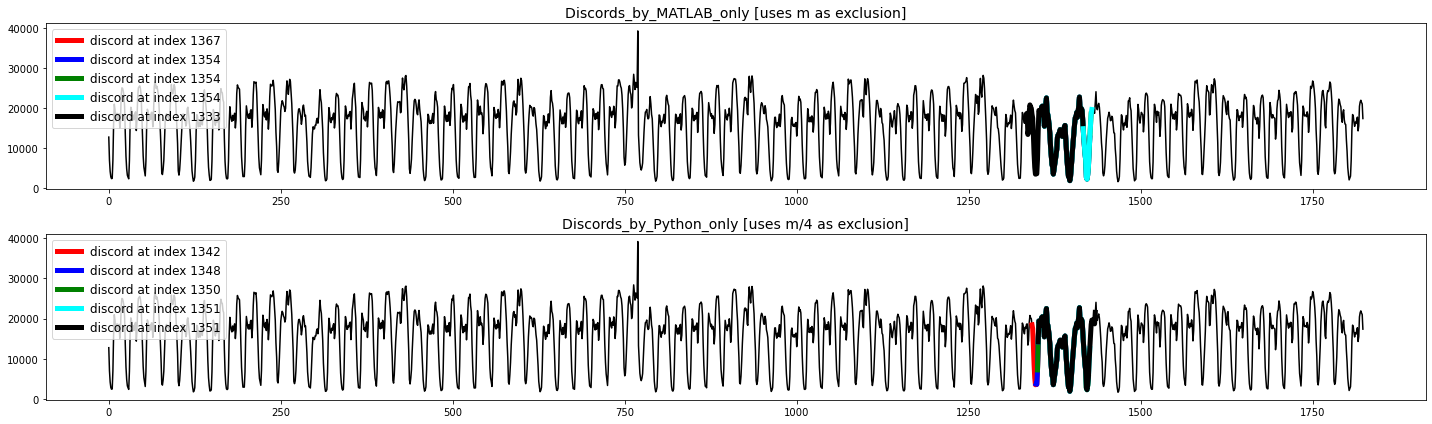

In [74]:
#finding discords that discovered by only Python (Table 3) or by only MATLAB (merlin3.m)
Discords_MATLAB = Discords_by_MATLAB[:,0] #by MATLAB code
Discords_Python = Discords[:,0] + 1 #by Python code (but with MATLAB indexing)

diff = Discords_MATLAB - Discords_Python
mask = np.where(diff != 0)[0]
print('mask: ', mask)

Discords_by_MATLAB_only = Discords_by_MATLAB[np.ix_(mask,)]
print("> Discords_by_MATLAB_only: \n", Discords_by_MATLAB_only)

Discords_by_Python_only = Discords[np.ix_(mask,)]
print(">  Discords_by_Python_only: \n", Discords_by_Python_only)

print('=======================================================================')

#plotting
n_discord = len(Discords_by_Python_only) #= len(Discords_by_MATLAB_only) = len(Discords_by_Python_only)
print('n_discord: ', n_discord)

fig, ax = plt.subplots(nrows=2, ncols=1)
ax[0].plot(ts, 'k')
ax[1].plot(ts , 'k')

color_vec = ['r','b','g','cyan', 'k']
for n in range(n_discord):
    idx = int(Discords_by_MATLAB_only[n][0])               
    m = int(Discords_by_MATLAB_only[n][1])
    ax[0].plot(np.arange(idx,idx+m), ts[idx:idx+m],c=color_vec[n], lw=5, label=f"discord at index {idx}")
    
    idx = int(Discords_by_Python_only[n][0])
    m = int(Discords_by_Python_only[n][1])
    ax[1].plot(np.arange(idx,idx+m), ts[idx:idx+m],c=color_vec[n], lw=5, label=f"discord at index {idx}")


ax[0].set_title("Discords_by_MATLAB_only [uses m as exclusion]",fontsize=14)
ax[1].set_title("Discords_by_Python_only [uses m/4 as exclusion]",fontsize=14)

ax[0].legend(fontsize=12)
ax[1].legend(fontsize=12)

fig.tight_layout()
plt.show()

## Let's use MERLIN on Mars Science Laboratory data (Fig. 17)

### Fig 17 (Top)

In [ ]:
df_MSL_topFigure = pd.read_csv("MERLIN_datasets\\Mars Science Laboratory\\A-4.csv", header=None) 
ts = np.reshape(df_MSL_topFigure.to_numpy(), newshape = (-1, ))

#plot data
plt.plot(ts)
plt.show()

#finging discords of different length
MinL = 100; MaxL = 200;
Discords = MERLIN(ts, MinL, MaxL)
print('----------------------------')
print('Discords are: ', Discords)
print('----------------------------')


#now, let's plot the discords
n_ts = len(ts)
fig, ax = plt.subplots(nrows=2, ncols=1)
ax[0].plot(ts)

ax[1].set_xlim(left=0, right=n_ts-1) 
ax[1].set_ylim(bottom=MaxL, top=MinL) 
for item in Discords:
    ax[1].scatter(x=int(item[0]), y=int(item[1]),c='r')

fig.tight_layout()
plt.show()

In [ ]:
#let's compare it with MATLAB:
Discords_by_MATLAB = pd.read_csv("MERLIN_datasets\\MSL_A_4_results_by_MATLAB\\MSL_A_4_MATLAB_results.csv", header=None).to_numpy()


for col in range(4):
    modification_val = 0
    if ((col==0) or (col==2)):
        modification_val = 1
    
    Discords_MATLAB = Discords_by_MATLAB[:,col] #by MATLAB code
    Discords_Python = Discords[:,col] + modification_val #by Python code (but with MATLAB indexing)
    
    diff = Discords_MATLAB - Discords_Python
    print(f'> differece at col={col}: \n {diff}')
    print('------------------------------------')

In [ ]:
#finding discords that discovered by only Python (Table 3) or by only MATLAB (merlin3.m)
Discords_MATLAB = Discords_by_MATLAB[:,0] #by MATLAB code
Discords_Python = Discords[:,0] + 1 #by Python code (but with MATLAB indexing)

diff = Discords_MATLAB - Discords_Python
mask = np.where(diff != 0)[0]
print('mask: ', mask)

Discords_by_MATLAB_only = Discords_by_MATLAB[np.ix_(mask,)]
print("> Discords_by_MATLAB_only: \n", Discords_by_MATLAB_only)

Discords_by_Python_only = Discords[np.ix_(mask,)]
print(">  Discords_by_Python_only: \n", Discords_by_Python_only)

### Fig 17 (Bottom)

In [ ]:
df_MSL_topFigure = pd.read_csv("MERLIN_datasets\\Mars Science Laboratory\\T-1.csv", header=None) 
ts = np.reshape(df_MSL_topFigure.to_numpy(), newshape = (-1, ))

#plot data
plt.figure(figsize=(20,2))
plt.plot(ts)
plt.show()

#finging discords of different length
MinL = 50; MaxL = 500;
Discords = MERLIN(ts, MinL, MaxL)
print('----------------------------')
print('Discords are: ', Discords)
print('----------------------------')


#now, let's plot the discords
n_ts = len(ts)
fig, ax = plt.subplots(nrows=2, ncols=1)
ax[0].plot(ts)

ax[1].set_xlim(left=0, right=n_ts-1) 
ax[1].set_ylim(bottom=MaxL, top=MinL) 
for item in Discords:
    ax[1].scatter(x=int(item[0]), y=int(item[1]),c='r')

fig.tight_layout()
plt.show()

# Implementing fastMERLIN (provided in the supporting page of the paper)

In [78]:
import time
import math
import copy

In [179]:
def fastMERLIN(T, minL, maxL, min_dist=None, min_sep_fraction = None, max_block_size=256, MERLIN_initializer=False):
    """
    Input:
    -------
    T: a 1d-array
    minL: discord's minimum length
    maxL: discord's maximum length
    min_dist: minimum "z-normalized euclidean distance" a discord should must have with its nearest neighbor
    If None, it is set to 2*sqrt(minL+1)
    min_sep_fraction: sets the exclusion zone width (from center) as sep = math.ceil(min_sep_fraction*min_sep_fraction). 
    So, the exclusion zone for i-th subsequence becomes [i-sep+1, i + sep -1]. If None, it is set
    to 1/4. It can take any value in (0,1]
    max_block_size: the block size based on which the algorithm find the candidates 
    

    Output:
    -------
    NOTE: num_L = maxL - minL + 1
    
    discord_indices: a 1d array of size num_L that stores the indices of all discovered discords
    discord_NN_indices: a 1d array of size num_L that stores the indices of discovered
    discords's nearest neighbors
    discord_dist: a 1d array of size num_L that stores the distance between each discord and
    its nearest neighbors
    discord_times: a 1d array of size num_L that stores the computation time spent for finding discords in seconds
    discord_misses: a 1d array of size num_L that stores the number of times that we had to reduce min_dist to
    allow algorithm find a discord
    """
    if min_dist is None:
        min_dist = 2 * np.sqrt(minL+1) #changed to minL+1 to consider stumpy's z-normalization
    
    #set min_sep if it is not set by the user
    if min_sep_fraction is None:
        min_sep_fraction = 1/4
    
    L_values = np.arange(minL, maxL+1)
    n_discords = len(L_values) #number of discords that will be discovered

    discord_indices = np.empty(n_discords, dtype='int')
    discord_NN_indices = np.empty(n_discords, dtype='int')
    discord_dists = np.empty(n_discords)

    discord_times = np.zeros(n_discords)
    discord_misses = np.zeros(n_discords, dtype='int')

    for i, L in enumerate(L_values):
        print('---')
        print(f'>>> L: {L}')
        tic = time.time()
        while True:
            print(f'.....ATTEMPT: #{discord_misses[i]}: USING min_dist: {min_dist}.....')
            tmp_discord_idx, tmp_discord_nn_idx, tmp_discord_dist = fastMerlin_helper(T, L, min_dist, min_sep_fraction, max_block_size)
            if len(tmp_discord_idx):
                break
            
            if i==0:
                min_dist = min_dist * 0.5
            elif MERLIN_initializer:
                min_dist = min_dist * 0.95
            else:
                min_dist = min_dist * (L-1) / L #use smaller L
            
            discord_misses[i] += 1
        
        top_loc = np.argmax(tmp_discord_dist)

        discord_indices[i] = tmp_discord_idx[top_loc]
        discord_NN_indices[i] = tmp_discord_nn_idx[top_loc]
        discord_dists[i] = tmp_discord_dist[top_loc]

        min_dist = discord_dists[i]
        toc = time.time()
        discord_times[i] = toc - tic
        print(f'CASE L={L}: computation time: {discord_times[i]} sec')
        
    return discord_indices, discord_NN_indices, discord_dists, discord_times, discord_misses


In [172]:
def fastMerlin_helper(T, L, min_dist, min_sep_fraction=None, max_block_size=256):
    """
    This function finds all discords of length L in time series T 
    and the discovered discords have minimum distance of min_dist to their nearest neighbor. 
    
    Input
    -----
    T: 1d-array time series
    L: length of discord
    min_dist: a minimum z-normalized euclidean distance that a discord must have with its nearest neighbor.
    min_sep_fraction: make the exclusion zone width (from center) as sep = math.ceil(min_sep_fraction*min_sep_fraction). 
    So, the exclusion zone for i-th subsequence becomes [i-sep+1, i + sep -1]
    max_block_size: the block size based on which the algorithm find the candidates 
    

    Output
    ------
    discord_idx: 1d-array that contains the indices of discovered candidates for discord of size L
    discord_nn_idx: 1d-array that contains the NN's indices of discovered candidates for discord of size L
    discord_dist: 1d-array that contains the distance between each candidate and its NN
    """
    #Check if inputs are correct
    if not (0 < min_dist <= 2 * np.sqrt(L+1)): #upper bound changed to 2*sqrt(L+1) to consider stumpy z-normalization
        raise ValueError("A valid choice of min_dist must be greater than 0 and less than or equal to 2*sqrt(L)")
        
    if not (4 <= L <= len(T)//2):
        raise ValueError("the  length of L must be in the range of 4 <= L <= floor(len(T)/2)")
    
    
    min_sep = math.ceil(L * min_sep_fraction)
    min_sep = min_sep + 1
    
    #calculate total number of subsequences with length L in T
    n = len(T) - L + 1
    
    #transforms min_dist into a correlation coefficient:
    r = (1 - (min_dist ** 2) / (2 * L)) * L # the outter *L is added because of using stumpy z-normalization 
    
    #transform all subsequences and keep them
    subsequences = np.zeros((n, L))
    for i in range(n):
        subsequences[i, :] = T[i: i+L]
    subsequences = stumpy.core.z_norm(subsequences, axis=1)
        
    if max_block_size is None:
        max_block_size = 256 #this is to check the data chunk by chunk
    num_block = math.ceil(len(T)/max_block_size)
    
    cand = np.zeros((n, L)) #to store candidates (filling from index 0)
    cand_index = np.zeros(n, dtype='int') # to store index that shows beginning of candidates (filling from index 0)
    counter = 0 #counter of discovered discords so far
    
    ###################################################
    ############## > phase I < ########################
    #In this phase we compare  the subsequences of a block with all discords found in previous blocks.
    #Also, we do within-block comparison to reject some of subsequences 
    
    print('#phase I: start!')
    for itr, i in enumerate(range(0, n, max_block_size)):
        print(f'{itr}-th block out of {num_block}')
        
        block_len = min(max_block_size, n - i) #to consider n % max_block_size != 0
        is_cand_in_block = np.full(block_len, True)
        
        #there are already some discords discovered from previous blocks
        
        if counter > 0: 
            is_cand_so_far = np.full(counter, True)
            if cand_index[:counter][0] <= i + block_len - min_sep - 1: #NOTE: this condition always true?
                last_cmp = np.where(cand_index[:counter] <= i + block_len - min_sep -1)[0][-1]
                
                if cand_index[:counter][0] > i - min_sep:
                    last_no_conflict = -1
                else:
                    last_no_conflict = np.where(cand_index[:counter][0] <= i - min_sep)[0][-1]
                
                    corr = np.matmul(cand[:(last_no_conflict+1), :], subsequences[i : (i + block_len), :].T)
                    mask = (corr > r) 
                    is_cand_in_block[np.any(mask, axis=0)] = False
                    is_cand_so_far[np.ix_(np.any(mask, axis=1))[0]] = False
                
                #we already checked discords upto last_no_conflict (inclusive),
                #now, we should compare the rest till last_cmp
                for pos in range(last_no_conflict+1, last_cmp+1):
                    first_cmp = max(i, cand_index[pos] + min_sep) #NOTE: this condition always true?
                    corr = np.matmul(cand[pos,:], subsequences[first_cmp: i+block_len, :].T)
                    eject_loc = np.where(corr > r)[0] + first_cmp - i
                    if eject_loc.size:
                        is_cand_so_far[pos] = False
                        is_cand_in_block[eject_loc] = False
                
                
                surviving_counter = np.sum(is_cand_so_far)
                if surviving_counter < counter: #if can be removed, but we may lose speed
                    counter = surviving_counter
                    tmp_loc = np.where(is_cand_so_far)[0]
                    cand_index[:counter] = cand_index[tmp_loc]
                    cand[:counter, :] = cand[tmp_loc, :]
                
    
        #within block comparison
        if block_len > min_sep:
            for pos in range(min_sep, block_len):
                corr = np.matmul(subsequences[i+pos,:], subsequences[i:i+pos-min_sep+1 ,:].T)
                mask = (corr > r)
                if np.sum(mask)>0:
                    is_cand_in_block[pos] = False
                    is_cand_in_block[np.where(mask)[0]] = False

    
        #update:
        cand_actual_idx = np.where(is_cand_in_block)[0] + i
        if len(cand_actual_idx)>0:
            prev_counter = counter
            counter = counter + len(cand_actual_idx)
            cand[prev_counter:counter,:] = subsequences[cand_actual_idx]
            cand_index[prev_counter:counter] = cand_actual_idx

    #############################################
    ############# >> phase II << ################
    #now, we compare the sequences of a blcok with all discords candidate
    #that located later in the time series
    
    print('#pahse II: start!')
    for itr, i in enumerate(range(0, n, max_block_size)):
        print(f'{itr}-th block out of {num_block}')
            
        if counter == 0:
            break
        
        is_cand_so_far = np.full(counter, True)
        block_len = min(max_block_size, n - i)
        
        min_index = max(i + block_len, i + min_sep)
        
        if cand_index[:counter][-1] < min_index:
            break #because there is no discord left after this block
        
        first_cmp = np.where(cand_index[:counter] >= min_index)[0][0]
        no_conflict_begin = i + block_len + min_sep
        
        if cand_index[:counter][-1] < no_conflict_begin:  #i.e. all discords aftet this block has a conflict
            first_no_conflict = counter #?
        else:
            first_no_conflict = np.where(cand_index[first_cmp:counter] >= no_conflict_begin)[0][0] + first_cmp
        
        for pos in range(first_cmp, first_no_conflict):
            corr = np.matmul(cand[pos,:], subsequences[i : cand_index[pos] - min_sep + 1, :].T)
            if np.any(corr > r):
                is_cand_so_far[pos] = False
        
        if first_no_conflict < counter:
            corr = np.matmul(cand[first_no_conflict:counter, :], subsequences[i:i+block_len ,:].T)
            mask = (corr > r)
            ejoct_loc = np.where(np.any(mask, axis=1))[0] + first_no_conflict
            is_cand_so_far[ejoct_loc] = False
        
        #update:
        surviving_counter = np.sum(is_cand_so_far)
        if  surviving_counter < counter:
            counter = surviving_counter
            tmp_loc = np.where(is_cand_so_far)[0]
            cand_index[:counter] = cand_index[tmp_loc]
            cand[:counter, :] = cand[tmp_loc, :]
        
    
    ################################################
    ############# >>> Phase III <<< ################
    #so far, we only discover the candidates, i.e. their distance to their NN 
    # bigger than min_dist

    #now, we try to find the NN of  the candidates in this phase
    
    
    #inilizing output
    discord_idx = cand_index[:counter] #not going to be changed!
    discord_nn_idx = -1 * np.ones(counter, dtype='int')
    discord_dist = -1 * np.ones(counter)
    
    cand = cand[:counter,:]
    cand_index = cand_index[:counter]
    
    print('#phase III: start!')
    if counter > 0:
        for itr, i in enumerate(range(0, n, max_block_size)):
            print(f'{itr}-th block out of {num_block}')
            block_len = min(max_block_size, n - i)
            
            #to see what discords can have conflict with the subsequences of block
            #NOTE: please note that the subsequences of block mean all the subseqeunces whose 
            #starting index is in the block!
            mask = (cand_index > i - min_sep) & (cand_index < i + block_len + min_sep -1) 
            
            with_conflicts = np.where(mask)[0]
            if not len(with_conflicts):
                first_conflict = counter
                last_conflict = []
            else:
                first_conflict = with_conflicts[0]
                last_conflict = with_conflicts[-1]
        
            if first_conflict >= 1:
                #so there are some discords (before first_conflict) that don't have conflict with block
                corr = np.matmul(cand[:first_conflict,:], subsequences[i:i+block_len,:].T)
                max_corr_idx = np.argmax(corr, axis=1)
                max_corr = corr[np.arange(corr.shape[0]), max_corr_idx]

                update = np.where(max_corr > discord_dist[:first_conflict])[0]
                discord_nn_idx[update] = max_corr_idx[update] + i
                discord_dist[update] = max_corr[update]
    
    
            if first_conflict < counter:
                #now, let's consider those discordss that have conflicts with current block
                for pos in range(first_conflict, last_conflict + 1):
                    #conflicting with ONLy the beginning of the block 
                    
                    if abs(cand_index[pos] - i) < min_sep:
                        if abs(cand_index[pos] - (i+block_len-1) ) >= min_sep : 
                            cmp_begin = cand_index[pos] + min_sep



                            corr = np.matmul(cand[pos,:], subsequences[cmp_begin : i + block_len, :].T)
                            max_corr_idx = np.argmax(corr)
                            max_corr = corr[max_corr_idx]
                            if max_corr > discord_dist[pos]:
                                discord_nn_idx[pos] = max_corr_idx + cmp_begin
                                discord_dist[pos] = max_corr

                    #conflicting with the end of the block 
                    elif abs(cand_index[pos] - (i+block_len-1) ) < min_sep:
                        corr = np.matmul(cand[pos,:], subsequences[i : (cand_index[pos] - min_sep + 1), :].T) # + 1?
                        max_corr_idx = np.argmax(corr)
                        max_corr = corr[max_corr_idx]
                        if max_corr > discord_dist[pos]:
                            discord_nn_idx[pos] = max_corr_idx + i
                            discord_dist[pos] = max_corr

                    #no conflict with the two ends of block (it is inside the block!)
                    else:
                        corr_left = np.matmul(cand[pos,:], subsequences[i : (cand_index[pos] - min_sep + 1), :].T)
                        corr_right = np.matmul(cand[pos,:], subsequences[(cand_index[pos] + min_sep) : i+block_len, :].T)
                        
                        max_corr_left_idx = np.argmax(corr_left)
                        max_corr_right_idx = np.argmax(corr_right)
                        
                        max_corr_left = corr_left[max_corr_left_idx]
                        max_corr_right = corr_right[max_corr_right_idx]
                        
                        if max_corr_left > max_corr_right:
                            max_corr = max_corr_left
                            max_corr_idx = max_corr_left_idx + i
                        else:
                            max_corr = max_corr_right
                            max_corr_idx = max_corr_right_idx + cand_index[pos] + min_sep

                        if max_corr > discord_dist[pos]:
                            discord_nn_idx[pos] = max_corr_idx
                            discord_dist[pos] = max_corr
                    
                    
                    
                if last_conflict < counter-1:
                    #i.e. there some discords after the block that
                    #do not have conflict with it
                    corr = np.matmul(cand[last_conflict+1:, :], subsequences[i: i+block_len].T)
                    max_corr_idx = np.argmax(corr, axis=1)
                    max_corr = corr[np.arange(corr.shape[0]), max_corr_idx]

                    update = np.where(max_corr > discord_dist[last_conflict+1:])[0]
                    discord_nn_idx[update+last_conflict+1] = max_corr_idx[update] + i
                    discord_dist[update+last_conflict+1] = max_corr[update]        

    print('end of three-phase process!')
    
    tmp = 2*L*(1-discord_dist/L)
    discord_dist = np.sqrt(np.where(tmp>0, tmp, 0))

    return discord_idx, discord_nn_idx, discord_dist

# Let's use fastMERLIN on TAXI data (Fig. 11)

we already applied MERLIN on TAXI data. Now, we would like to see the result by using fastMERLIN

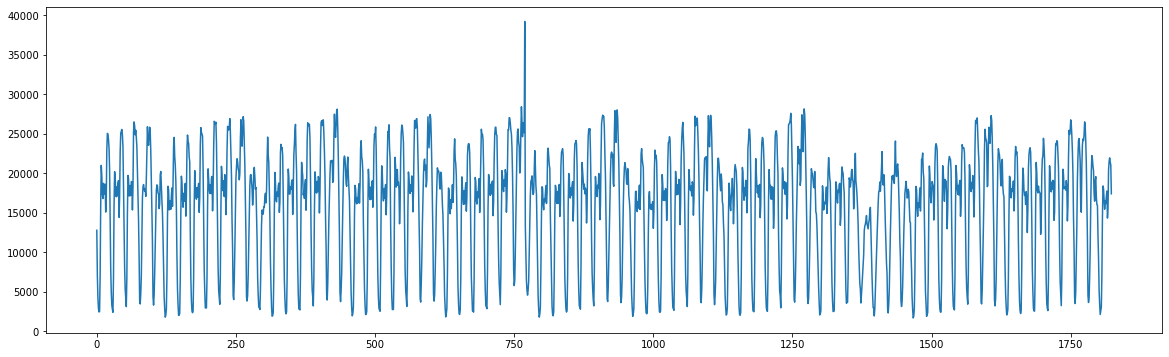

In [173]:
#read data
df_taxi = pd.read_csv("MERLIN_datasets\\NAB_NYC_TAXI\\data\\realKnownCause\\nyc_taxi.csv") 
df_taxi = df_taxi.set_index(['timestamp'])

#select the range of dates considered in the paper
data =  df_taxi.loc['2014-10-01 00:00:00' : '2014-12-15 23:00:00']

ts = np.reshape(data.to_numpy(),newshape=(-1,))
#let's consider only the data at each hour (not the half hours)
ts = [val for i,val in enumerate(ts) if i % 2 == 0]
ts = np.asarray(ts)

#to use it later in  MATLAB 
np.savetxt("taxi_to_reproduce_paper.csv", ts, delimiter=",")

#plottting
plt.plot(ts)
plt.show()

In [82]:
#apply fastMERLIN
(discord_indices, 
 discord_NN_indices, 
 discord_dists, 
 discord_times, 
 discord_misses) = fastMERLIN(ts, 
                               5, 96,
                               min_dist=None
                             )


discord_indices_fastMERLIN = discord_indices
discord_NN_indices_fastMERLIN =  discord_NN_indices
discord_dists_fastMERLIN = discord_dists
time_fastMERLIN = discord_times

print('fastMERLIN takes: ', sum(time_fastMERLIN))

---
>>> L: 5
.....ATTEMPT: #0: USING min_dist: 4.898979485566356.....
#phase I: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
6-th block out of 8
7-th block out of 8
#pahse II: start!
0-th block out of 8
#phase III: start!
end of three-phase process!
.....ATTEMPT: #1: USING min_dist: 3.919183588453085.....
#phase I: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
6-th block out of 8
7-th block out of 8
#pahse II: start!
0-th block out of 8
#phase III: start!
end of three-phase process!
.....ATTEMPT: #2: USING min_dist: 3.1353468707624677.....
#phase I: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
6-th block out of 8
7-th block out of 8
#pahse II: start!
0-th block out of 8
#phase III: start!
end of three-phase process!
.....ATTEMPT: #3: USING min_d

1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
6-th block out of 8
7-th block out of 8
#pahse II: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
#phase III: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
6-th block out of 8
7-th block out of 8
end of three-phase process!
CASE L=15: computation time: 0.03390955924987793 sec
---
>>> L: 16
.....ATTEMPT: #0: USING min_dist: 3.726216368849502.....
#phase I: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
6-th block out of 8
7-th block out of 8
#pahse II: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
#phase III: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
6-th block out of 8
7-th block out of 8
end of three-phas

5-th block out of 8
6-th block out of 8
7-th block out of 8
#pahse II: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
#phase III: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
6-th block out of 8
7-th block out of 8
end of three-phase process!
CASE L=24: computation time: 0.04487967491149902 sec
---
>>> L: 25
.....ATTEMPT: #0: USING min_dist: 2.5845448370266615.....
#phase I: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
6-th block out of 8
7-th block out of 8
#pahse II: start!
0-th block out of 8
1-th block out of 8
#phase III: start!
end of three-phase process!
.....ATTEMPT: #1: USING min_dist: 2.481163043545595.....
#phase I: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
6-th block out of 8
7-th block out

2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
6-th block out of 8
#pahse II: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
#phase III: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
6-th block out of 8
end of three-phase process!
CASE L=37: computation time: 0.039893388748168945 sec
---
>>> L: 38
.....ATTEMPT: #0: USING min_dist: 3.744807355007558.....
#phase I: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
6-th block out of 8
#pahse II: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
#phase III: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
6-th block out o

#phase I: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
6-th block out of 8
#pahse II: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
#phase III: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
6-th block out of 8
end of three-phase process!
CASE L=49: computation time: 0.042885780334472656 sec
---
>>> L: 50
.....ATTEMPT: #0: USING min_dist: 4.271308538299571.....
#phase I: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
6-th block out of 8
#pahse II: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
#phase III: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8

5-th block out of 8
6-th block out of 8
#pahse II: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
#phase III: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
6-th block out of 8
end of three-phase process!
CASE L=65: computation time: 0.05086493492126465 sec
---
>>> L: 66
.....ATTEMPT: #0: USING min_dist: 5.364078586002389.....
#phase I: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
6-th block out of 8
#pahse II: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
#phase III: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
6-th block out of 8
end of three-phase process!
CASE L=66: computation time: 

3-th block out of 8
4-th block out of 8
5-th block out of 8
6-th block out of 8
end of three-phase process!
CASE L=79: computation time: 0.03987526893615723 sec
---
>>> L: 80
.....ATTEMPT: #0: USING min_dist: 5.78515785246045.....
#phase I: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
6-th block out of 8
#pahse II: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
#phase III: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
6-th block out of 8
end of three-phase process!
CASE L=80: computation time: 0.04886960983276367 sec
---
>>> L: 81
.....ATTEMPT: #0: USING min_dist: 5.827777243041034.....
#phase I: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
6-th block out of 8
#pahse

2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
6-th block out of 8
#pahse II: start!
0-th block out of 8
1-th block out of 8
#phase III: start!
end of three-phase process!
.....ATTEMPT: #1: USING min_dist: 6.258388792688763.....
#phase I: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
6-th block out of 8
#pahse II: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
#phase III: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
6-th block out of 8
end of three-phase process!
CASE L=94: computation time: 0.08078169822692871 sec
---
>>> L: 95
.....ATTEMPT: #0: USING min_dist: 6.309159708057134.....
#phase I: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out 

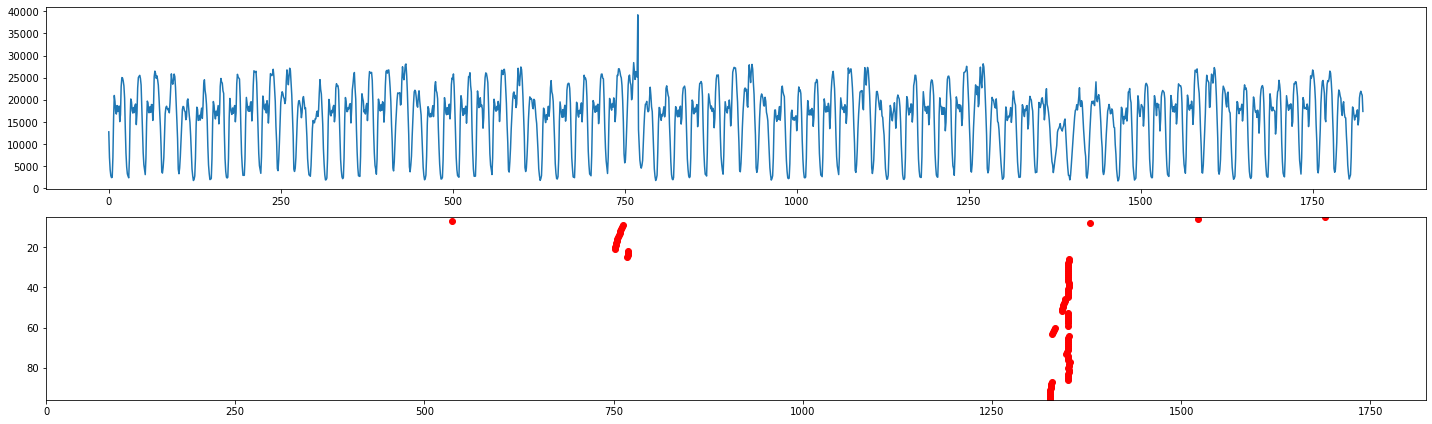

time_fastMERLIN:  5.420485734939575


In [83]:
#plot discords indices and their corresponding length
n_ts = len(ts)

fig, ax = plt.subplots(nrows=2, ncols=1)
ax[0].plot(ts)

ax[1].set_xlim(left=0, right=n_ts-1) 
ax[1].set_ylim(bottom=96, top=5) 
for i, L in enumerate(np.arange(5,97)):
    ax[1].scatter(x=discord_indices[i], y=L, c='r')

fig.tight_layout()
plt.show()

print('time_fastMERLIN: ', sum(time_fastMERLIN))

To make sure the results of MERLIN and fastMERLIN are the same, we apply MERLIN below and compare its result 
with what achieved by fastMERLIN

In [84]:
tic = time.time()
Discords = MERLIN(ts, 5, 96, separation_fraction=None) #separation_fraction=None: means stumpy default setting for ignoring trivial checks
toc = time.time()

#computation time:
time_MERLIN = toc - tic

Stage#1: Calculating the first discord...
Discords after finding the first one: 
 [1690, 5, 1120, 1.3642079150627304]
Stage#2: Calculating the next four discords...
>>> Discords after finding the next four discords:  [1522, 6, 1100, 1.4064712539239808]
>>> Discords after finding the next four discords:  [537, 7, 1689, 1.62928107746437]
>>> Discords after finding the next four discords:  [1380, 8, 443, 1.746810126819628]
>>> Discords after finding the next four discords:  [762, 9, 1328, 2.0634858945465493]
Stage#3: Calculating the remaining discords...
>>> new discord:  [761, 10, 1327, 2.1247537919540944]
>>> new discord:  [760, 11, 1381, 2.629462897528745]
>>> new discord:  [759, 12, 1380, 2.746225055671875]
>>> new discord:  [758, 13, 1379, 2.9819137944892202]
>>> new discord:  [757, 14, 1261, 3.5977491081910626]
>>> new discord:  [756, 15, 1260, 3.7262163688495025]
>>> new discord:  [755, 16, 1259, 3.8542112273477858]
>>> new discord:  [754, 17, 1258, 3.773480491623614]
>>> new disco

In [85]:
discord_indices_MERLIN = np.array([int(x) for x in Discords[:,0]])
discord_NN_indices_MERLIN =  np.array([int(x) for x in Discords[:,1]])
discord_dists_MERLIN = Discords[:,3]

print('computation time when using MERLIN: ', time_MERLIN) 

computation time when using MERLIN:  395.71951818466187


please note that we are z-normalizing each subseq in each iteration. creating the all_subsequnces matrix and having the z-normalized subsequences ready might reduce the computation time. Therefore, to compare MERLIN and fastMERLIN regarding their computation time, we used the MATLAB code!

## Using Matrix Profile to get discords

In [86]:
ts = ts.astype(np.float64)

#let's use matrix profile
n_discords = 96 - 5 + 1

discord_indices_MP = np.zeros(n_discords, dtype='int')
discord_NN_indices_MP = np.zeros(n_discords, dtype='int')
discord_dists_MP = np.zeros(n_discords)
time_MP = np.zeros(n_discords)

for i, L in enumerate(np.arange(5,97)):
    print(f'L={L}', end='>>>')
    tic = time.time()
    
    mp = stumpy.stump(ts, L, ignore_trivial=True, normalize=True)
    idx = np.argmax(mp[:,0])
    
    discord_indices_MP[i] = idx
    discord_NN_indices_MP[i] = mp[idx,1]
    discord_dists_MP[i] = mp[idx,0]
    
    toc = time.time()
    time_MP[i] = toc - tic

L=5>>>L=6>>>L=7>>>L=8>>>L=9>>>L=10>>>L=11>>>L=12>>>L=13>>>L=14>>>L=15>>>L=16>>>L=17>>>L=18>>>L=19>>>L=20>>>L=21>>>L=22>>>L=23>>>L=24>>>L=25>>>L=26>>>L=27>>>L=28>>>L=29>>>L=30>>>L=31>>>L=32>>>L=33>>>L=34>>>L=35>>>L=36>>>L=37>>>L=38>>>L=39>>>L=40>>>L=41>>>L=42>>>L=43>>>L=44>>>L=45>>>L=46>>>L=47>>>L=48>>>L=49>>>L=50>>>L=51>>>L=52>>>L=53>>>L=54>>>L=55>>>L=56>>>L=57>>>L=58>>>L=59>>>L=60>>>L=61>>>L=62>>>L=63>>>L=64>>>L=65>>>L=66>>>L=67>>>L=68>>>L=69>>>L=70>>>L=71>>>L=72>>>L=73>>>L=74>>>L=75>>>L=76>>>L=77>>>L=78>>>L=79>>>L=80>>>L=81>>>L=82>>>L=83>>>L=84>>>L=85>>>L=86>>>L=87>>>L=88>>>L=89>>>L=90>>>L=91>>>L=92>>>L=93>>>L=94>>>L=95>>>L=96>>>

### NOW, let's compare fastMERLIN vs MP (and vs MERLIN):

Here, we try to substract the arrays that contain the corresponding info for discords of length 5-96 (i.e. length of array: 92)

In [87]:
#To compare indices of discords

print('>>> diff between discord indices discovered by fastMERLIN and MP: \n', discord_indices_fastMERLIN - discord_indices_MP)
print('---------------------------------------------')
print('>>> diff between discord indices discovered by MERLIN and MP: \n', discord_indices_MERLIN - discord_indices_MP)


>>> diff between discord indices discovered by fastMERLIN and MP: 
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
---------------------------------------------
>>> diff between discord indices discovered by MERLIN and MP: 
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [88]:
print('fastMERLIN computation time: ', np.sum(time_fastMERLIN))

print('MP computation time: ', np.sum(time_MP))

fastMERLIN computation time:  5.420485734939575
MP computation time:  1.2027673721313477


In [89]:
#to check it with MERLIN MATLAB if there is bug:
MERLIN_bug_idx = np.where(discord_indices_MERLIN - discord_indices_MP > 0)[0]
print('potential bug of MERLIN located at index (of output array): ', MERLIN_bug_idx)
print('indices discovered by Python MERLIN are: ', discord_indices_MERLIN[MERLIN_bug_idx])

potential bug of MERLIN located at index (of output array):  []
indices discovered by Python MERLIN are:  []


**NOTE:** After checking out the output of MATLAB MERLIN for the above cases, it seems the MATLAB MERLIN is not correct as the results are not similar to what achieved by STUMpy MatrixProfile. We can see a similar problem in differences in the dist-to-NN shown below

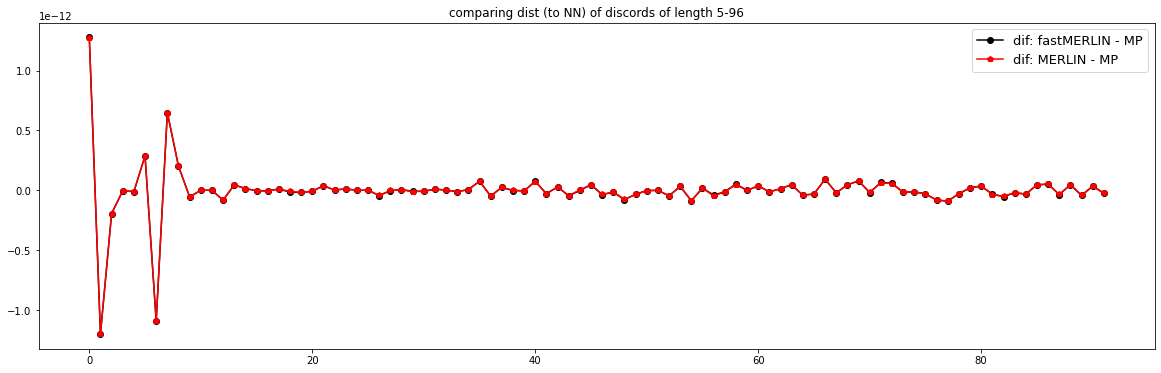

In [90]:
#To compare dist of discords to their NN, we plot the difference between fastMERLIN/MERLIN and MP 
plt.figure()
plt.title('comparing dist (to NN) of discords of length 5-96')

plt.plot(discord_dists_fastMERLIN - discord_dists_MP, c='k', marker='o', label='dif: fastMERLIN - MP')
plt.plot(discord_dists_MERLIN - discord_dists_MP, c='r', marker='p', label='dif: MERLIN - MP')

plt.legend(loc=1, fontsize=13)
plt.show()

In [91]:
#To compare NN indices of discords

print('>>> diff between discord NN indices discovered by fastMERLIN and MP: \n', discord_NN_indices_fastMERLIN - discord_NN_indices_MP)
print('---------------------------------------------')
print('>>> diff between discord NN indices discovered by MERLIN and MP: \n', discord_NN_indices_MERLIN - discord_NN_indices_MP)


>>> diff between discord NN indices discovered by fastMERLIN and MP: 
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
---------------------------------------------
>>> diff between discord NN indices discovered by MERLIN and MP: 
 [-1115 -1094 -1682  -435 -1319 -1317 -1370 -1368 -1366 -1247 -1245 -1243
 -1241 -1239 -1574 -1572 -1571   -75   -74   -73   -71 -1375 -1374 -1372
  -220  -219  -218  -217  -216  -215  -214  -213  -212  -212  -210  -209
  -207  -206  -204  -203  -202  -199  -197  -195  -193  -192  -190  -188
  -195  -194  -193  -192  -191  -190  -189  -171  -169  -167  -164  -903
  -901  -900  -899  -898  -897  -895  -894  -892  -890 -1228 -1226 -1226
  -891    70    71    73 -1439 -1438 -1436 -1435 -1433 -1432  -858 -1072
 -1407 -1406 -1404 -1547 -1546  -537 -1543 -1542]


**NOTE:** fastMERLIN preserves the order of subsequences. Therefore, it is possible to have more than 1 NN. However, MERLIN cannot preserve the order of subsequences as they appear in T. Therefore, we might end up with different NN when we use MERLIN.

## Let's compare fastMERLIN and MP for another data set (used in the paper)

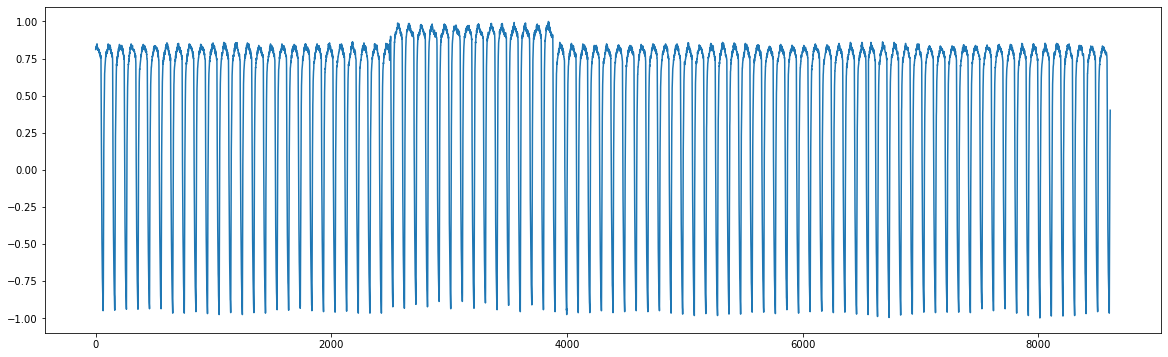

with length:  8612


In [92]:
df_MSL_topFigure = pd.read_csv("MERLIN_datasets\\Mars Science Laboratory\\T-1.csv", header=None)
ts = np.reshape(df_MSL_topFigure.to_numpy(), newshape = (-1, ))
ts = ts.astype(np.float64)

plt.plot(ts)
plt.show()
print('with length: ', len(ts))

In [93]:
#setting  the lower bound and upper bound for the length of discords
minL = 50; maxL = 500;
L_vec =  np.arange(minL,maxL+1)

In [94]:
#use MP:
n_discords = maxL - minL + 1

discord_indices_MP = np.zeros(n_discords, dtype='int')
discord_NN_indices_MP = np.zeros(n_discords, dtype='int')
discord_dists_MP = np.zeros(n_discords)
time_MP = np.zeros(n_discords)

for i, L in enumerate(np.arange(minL,maxL+1)):
    print(f'L={L}', end='>>>')
    tic = time.time()
    
    mp = stumpy.stump(ts, L, ignore_trivial=True, normalize=True)
    idx = np.argmax(mp[:,0])
    
    discord_indices_MP[i] = idx
    discord_NN_indices_MP[i] = mp[idx,1]
    discord_dists_MP[i] = mp[idx,0]
    
    toc = time.time()
    time_MP[i] = toc - tic

L=50>>>L=51>>>L=52>>>L=53>>>L=54>>>L=55>>>L=56>>>L=57>>>L=58>>>L=59>>>L=60>>>L=61>>>L=62>>>L=63>>>L=64>>>L=65>>>L=66>>>L=67>>>L=68>>>L=69>>>L=70>>>L=71>>>L=72>>>L=73>>>L=74>>>L=75>>>L=76>>>L=77>>>L=78>>>L=79>>>L=80>>>L=81>>>L=82>>>L=83>>>L=84>>>L=85>>>L=86>>>L=87>>>L=88>>>L=89>>>L=90>>>L=91>>>L=92>>>L=93>>>L=94>>>L=95>>>L=96>>>L=97>>>L=98>>>L=99>>>L=100>>>L=101>>>L=102>>>L=103>>>L=104>>>L=105>>>L=106>>>L=107>>>L=108>>>L=109>>>L=110>>>L=111>>>L=112>>>L=113>>>L=114>>>L=115>>>L=116>>>L=117>>>L=118>>>L=119>>>L=120>>>L=121>>>L=122>>>L=123>>>L=124>>>L=125>>>L=126>>>L=127>>>L=128>>>L=129>>>L=130>>>L=131>>>L=132>>>L=133>>>L=134>>>L=135>>>L=136>>>L=137>>>L=138>>>L=139>>>L=140>>>L=141>>>L=142>>>L=143>>>L=144>>>L=145>>>L=146>>>L=147>>>L=148>>>L=149>>>L=150>>>L=151>>>L=152>>>L=153>>>L=154>>>L=155>>>L=156>>>L=157>>>L=158>>>L=159>>>L=160>>>L=161>>>L=162>>>L=163>>>L=164>>>L=165>>>L=166>>>L=167>>>L=168>>>L=169>>>L=170>>>L=171>>>L=172>>>L=173>>>L=174>>>L=175>>>L=176>>>L=177>>>L=178>>>L=179>>>L=180>>>L=

In [95]:
#use fastMERLIN:
(discord_indices, 
 discord_NN_indices, 
 discord_dists, 
 discord_times, 
 discord_misses) = fastMERLIN(ts, 
                               minL, maxL,
                               min_dist=None
                             )


discord_indices_fastMERLIN = discord_indices
discord_NN_indices_fastMERLIN =  discord_NN_indices
discord_dists_fastMERLIN = discord_dists
time_fastMERLIN = discord_times

print('fastMERLIN takes: ', sum(time_fastMERLIN))

---
>>> L: 50
.....ATTEMPT: #0: USING min_dist: 14.2828568570857.....
#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
#phase III: start!
end of three-phase process!
.....ATTEMPT: #1: USING min_dist: 13.997199719943987.....
#phase I: start!
0-th block out

11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
#phase III: start!
end of three-phase process!
.....ATTEMPT: #10: USING min_dist: 11.670133942592058.....
#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block 

#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
#phase III: start!
end of three-phase process!
.....ATTEMPT: #20: USING min_dist: 9.535349097227328.....
#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34


2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
#phase III: start!
end of three-phase process!
.....ATTEMPT: #30: USING min_dist: 7.791074451524167.....
#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of

#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
33-th block out of 34
end of three-ph

13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
#phase III: start!
end of three-phase process!
.....ATTEMPT: #1: USING min_dist: 7.953524412919914.....
#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out

31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
#phase III: start!
end of three-phase process!
.....ATTEMPT: #1: USING min_dist: 7.720685394228765.....
#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: star

13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
#phase III: start!
end of three-phase process!
.....ATTEMPT: #1: USING min_dist: 7.375045943486553.....
#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out

7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out 

#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
#phase III: start!
end of three-phase process!
.....ATTEMPT: #3: USING min_dist: 6.233271731512213.....
#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
2

27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
#phase III: start!
end of three-phase process!
.....ATTEMPT: #1: USING min_dist: 6.1083386709022784.....
#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block ou

32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
#phase III: start!
end of three-phase process!
.....ATTEMPT: #4: USING min_dist: 5.628562408534041.....
#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
2

#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out

#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
#phase III: start!
end of three-phase process!
.....ATTEMPT: #3: USING min_dist: 5.715390632525536.....
#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
2

#pahse II: start!
0-th block out of 34
1-th block out of 34
#phase III: start!
end of three-phase process!
.....ATTEMPT: #1: USING min_dist: 5.9233083475631085.....
#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34

32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
#phase III: start!
end of three-phase process!
.....ATTEMPT: #1: USING min_dist: 6.00109815630689.....
#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34

17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th b

33-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out

15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#p

6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th 

31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out

18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th bl

#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out

26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out

#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out

#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out

29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out

15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#p

14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25

8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-t

CASE L=137: computation time: 0.1795206069946289 sec
---
>>> L: 138
.....ATTEMPT: #0: USING min_dist: 11.375305934031694.....
#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of

#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out

32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out

22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block 

22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block 

14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25

26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out

25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out

27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out

21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block 

17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th bl

3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th blo

28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out

24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out

29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out

13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25

17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th bl

6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th 

19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
end of three-phase process!
CASE L=210: computation time: 0.18550395965576172 sec
---
>>> L: 211
.....ATTEMPT: 

24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out

26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out

8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-t

#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out o

#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out o

3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th blo

0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block 

#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out o

#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out o

2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th bloc

16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th b

15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th 

19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th bloc

#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
end of three-phase process!
.....ATTEMPT: #2: USING min_dist: 14.810713405993141.....
#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34


23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block ou

22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
end of three-phase process!
.....ATTEMPT: #2: USING min_dist: 14.518120908620535.....
#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out

25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
end of three-phase process!
.....ATTEMPT: #2: USING min_dist: 14.355848416460876.....
#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of

29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
#phase III: start!
end of three-phase process!
.....ATTEMPT: #1: USING min_dist: 14.19810938361991.....
#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: star

25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out

32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
#phase III: start!
end of three-phase process!
.....ATTEMPT: #2: USING min_dist: 13.806931784729736.....
#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
#phase III: start!
e

25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out

19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th bloc

19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th bloc

21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block 

18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th blo

25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out

23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block ou

17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th bl

19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th bloc

25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out

22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block o

20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block 

22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block ou

22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block ou

15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
#phase III: start!
0-th block out of 34
1-th b

25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out

25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out

23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out

25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out

25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out

23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out

25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
#phase III: start!
end of three-phase process!
.....ATTEMPT: #1: USING min_dist: 15.096888800340391.....
#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block ou

25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out

#pahse II: start!
0-th block out of 34
1-th block out of 34
#phase III: start!
end of three-phase process!
.....ATTEMPT: #1: USING min_dist: 14.81909638655368.....
#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
#phase III: start!
end of three-phase proce

#pahse II: start!
0-th block out of 34
1-th block out of 34
#phase III: start!
end of three-phase process!
.....ATTEMPT: #2: USING min_dist: 14.631468548016292.....
#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
#phase III: start!
end of three-phase proc

29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
#phase III: start!
end of three-phase process!
.....ATTEMPT: #1: USING min_dist: 14.492939392288042.....
#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: sta

#pahse II: start!
0-th block out of 34
1-th block out of 34
#phase III: start!
end of three-phase process!
.....ATTEMPT: #1: USING min_dist: 14.299522690180606.....
#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
#phase III: start!
end of three-phase proc

#pahse II: start!
0-th block out of 34
1-th block out of 34
#phase III: start!
end of three-phase process!
.....ATTEMPT: #1: USING min_dist: 14.111376668799688.....
#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
#phase III: start!
end of three-phase proc

25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out

4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th bl

14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
#phase III: start!
0-th 

24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out

18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th bloc

16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th bl

#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out o

#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out o

18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th bloc

19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block

16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th bl

#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out o

5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th b

#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out o

7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th

9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-

1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block

7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th

#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out o

#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out o

18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block

#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out o

2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
#phase III: start!
end of three-phase process!
.....ATTEMPT: #1: USING min_dist: 19.792895108508755.....
#phase I: start

#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out o

#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
#phase III: start!
end of three-phase process!
.....ATTEMPT: #1: USING min_dist: 19.562151857013742.....
#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-

#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
#phase III: start!
end of three-phase process!
.....ATTEMPT: 

#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out o

1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
#phase III: start!
end of three-phase process!
.....ATTEMPT: #1: USING min_dist: 19.277314425258183

#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out o

23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out

16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
#phase III: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th blo

#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out o

total diff in indices of discords: 
 0
-------------------------
total diff in NN indices of discords: 
 0
-------------------------
diff in indices of dist-to-NN: see the figure below!


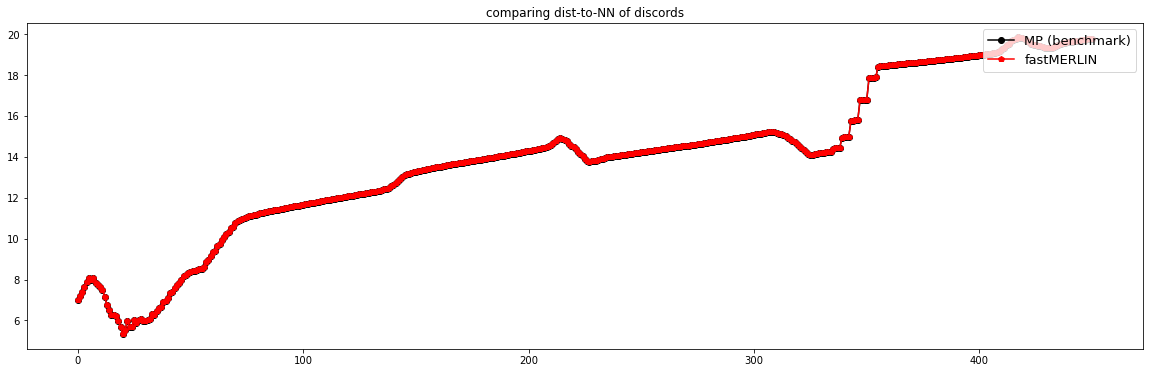

-------------------------
fastMERLIN computation time:  133.97817730903625
MP computation time:  57.372536182403564


In [96]:
print('total diff in indices of discords: \n', np.sum(abs(discord_indices_fastMERLIN - discord_indices_MP)) )
print('-------------------------')
print('total diff in NN indices of discords: \n', np.sum(abs(discord_NN_indices_fastMERLIN - discord_NN_indices_MP)) )
print('-------------------------')

print('diff in indices of dist-to-NN: see the figure below!')
plt.figure()
plt.title('comparing dist-to-NN of discords')

plt.plot(discord_dists_MP, c='k', marker='o', label='MP (benchmark)')
plt.plot(discord_dists_fastMERLIN, c='r', marker='p', label='fastMERLIN')

plt.legend(loc=1, fontsize=13)
plt.show()
      
print('-------------------------')
print('fastMERLIN computation time: ', np.sum(time_fastMERLIN))
print('MP computation time: ', np.sum(time_MP))

In [97]:
#to debug fastMERLIN:
bugs_loc = np.where(discord_indices_fastMERLIN - discord_indices_MP != 0)[0]

bugs_dict = {}

bugs_dict['loc'] =  bugs_loc
bugs_dict['length'] = L_vec[bugs_loc]

bugs_dict['indices by fastMERLIN'] = discord_indices_fastMERLIN[bugs_loc]
bugs_dict['NN indices by fastMERLIN'] = discord_NN_indices_fastMERLIN[bugs_loc]
bugs_dict['dist by fastMERLIN'] = discord_dists_fastMERLIN[bugs_loc]

bugs_dict['indices by MP'] = discord_indices_MP[bugs_loc]
bugs_dict['NN indices by MP'] = discord_NN_indices_MP[bugs_loc]
bugs_dict['dist by MP'] = discord_dists_MP[bugs_loc]

df = pd.DataFrame(bugs_dict)
df #if empty, that means there is no problem

Empty DataFrame
Columns: [loc, length, indices by fastMERLIN, NN indices by fastMERLIN, dist by fastMERLIN, indices by MP, NN indices by MP, dist by MP]
Index: []

## Compare fastMERLIN and STUMPY on different cases

In [119]:
def discord_finder_MP(T, minL, maxL):
    n_discords = maxL - minL + 1
    
    discord_indices_MP = np.zeros(n_discords, dtype='int')
    discord_NN_indices_MP = np.zeros(n_discords, dtype='int')
    discord_dists_MP = np.zeros(n_discords)
    time_MP = np.zeros(n_discords)

    for i, L in enumerate(np.arange(minL,maxL+1)):
        print(f'L={L}', end='>>>')
        tic = time.time()

        mp = stumpy.stump(ts, L, ignore_trivial=True, normalize=True)
        idx = np.argmax(mp[:,0])

        discord_indices_MP[i] = idx
        discord_NN_indices_MP[i] = mp[idx,1]
        discord_dists_MP[i] = mp[idx,0]

        toc = time.time()
        time_MP[i] = toc - tic
    
    return discord_indices_MP, discord_NN_indices_MP, discord_dists_MP, time_MP

In below, we read data and we create a longer version of by expanding the time series from left(right) of anomaly segement.

In [121]:
expand_factor = 50 #will be used to expand the time series

### since data

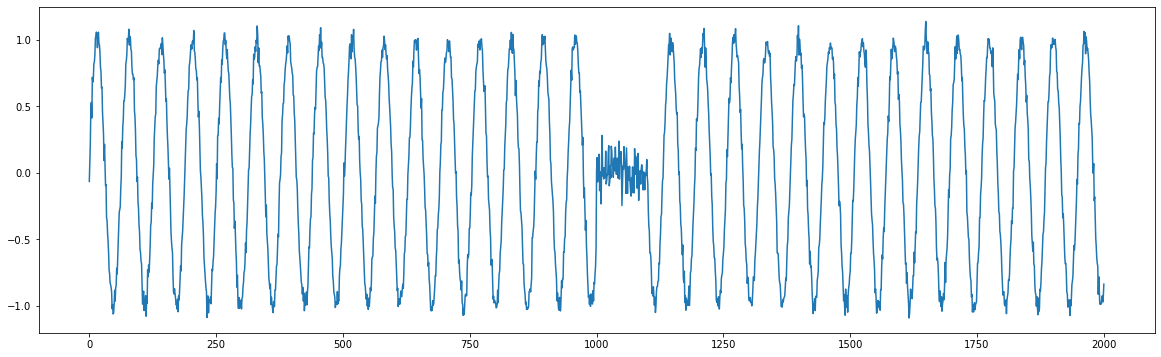

In [186]:
#sine data (short)
data = loadmat("MERLIN_datasets\\NoisySine.mat") 
ts_sine = data['T'].reshape(-1,)
ts_sine = ts_sine.astype(np.float64)

plt.plot(ts_sine)
plt.show()

In [187]:
#sine data (long): expanding from left and right
tmp_left = np.tile(ts_sine[:750], expand_factor)
tmp_middle = np.tile(ts_sine[750:1250], 1)
tmp_right = np.tile(ts_sine[1250:], expand_factor)

ts_sine_long = np.r_[tmp_left, tmp_middle, tmp_right]
print('lenght of ts_sine_long: ', len(ts_sine_long))

lenght of ts_sine_long:  75550


### taxi data

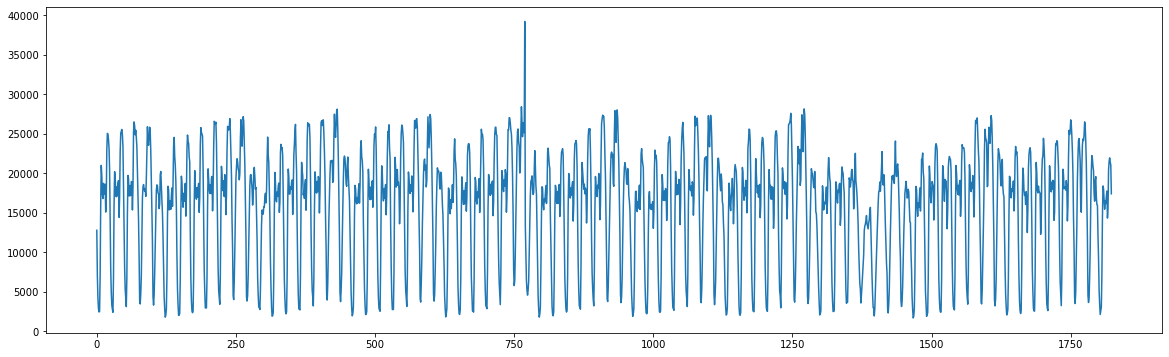

In [188]:
#taxi data 
df_taxi = pd.read_csv("MERLIN_datasets\\NAB_NYC_TAXI\\data\\realKnownCause\\nyc_taxi.csv") 
df_taxi = df_taxi.set_index(['timestamp'])
data =  df_taxi.loc['2014-10-01 00:00:00' : '2014-12-15 23:00:00']

ts_taxi = np.reshape(data.to_numpy(),newshape=(-1,))

#let's consider only the data at each hour (not the half hours)
ts_taxi = [val for i,val in enumerate(ts_taxi) if i % 2 == 0]
ts_taxi = np.asarray(ts_taxi, dtype='float64')

plt.plot(ts_taxi)
plt.show()

In [189]:
#taxi data (long)

tmp_left = np.tile(ts_taxi[:500], expand_factor)
tmp_middle = np.tile(ts_taxi[500:1000], 1)
tmp_right = np.tile(ts_taxi[1000:], expand_factor)

ts_taxi_long = np.r_[tmp_left, tmp_middle, tmp_right]
print('lenght of ts_taxi_long: ', len(ts_taxi_long))

lenght of ts_taxi_long:  66700


### Sinence Lab Data

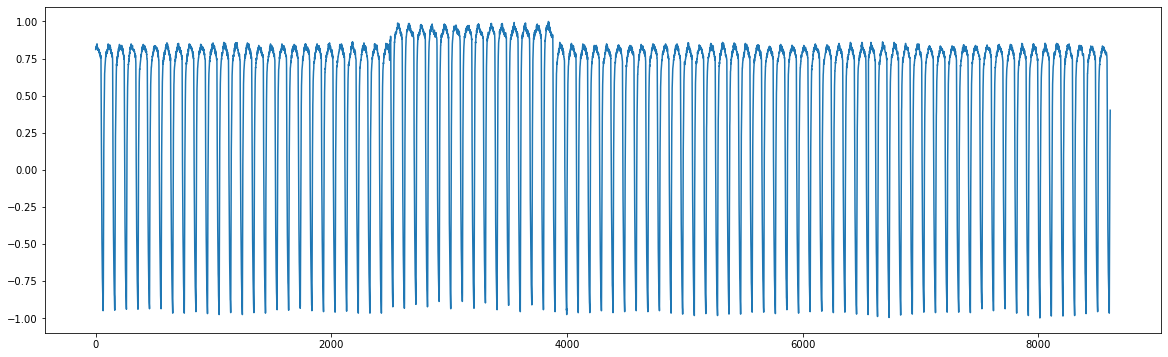

In [190]:
#science lab data
df_MSL_topFigure = pd.read_csv("MERLIN_datasets\\Mars Science Laboratory\\T-1.csv", header=None)
ts_lab = np.reshape(df_MSL_topFigure.to_numpy(), newshape = (-1, ))
ts_lab = ts_lab.astype(np.float64)

plt.plot(ts_lab)
plt.show()

In [193]:
#lab data (long)

tmp_left = np.tile(ts_lab[:2000], expand_factor//3)
tmp_middle = np.tile(ts_lab[2000:4000], 1)
tmp_right = np.tile(ts_lab[4000:], expand_factor//3)

ts_lab_long = np.r_[tmp_left, tmp_middle, tmp_right]
print('lenght of ts_lab_long: ', len(ts_lab_long))

lenght of ts_lab_long:  107792


In [195]:
ts_names_list = ['ts_sine', 'ts_taxi', 'ts_lab']

ts_short = {'ts_sine': ts_sine, 
            'ts_taxi': ts_taxi,
            'ts_lab': ts_lab
           }

ts_long = {'ts_sine': ts_sine_long, 
            'ts_taxi': ts_taxi_long,
            'ts_lab': ts_lab_long
           }

discord_length_choices = {'ts_sine': (500,510), 
               'ts_taxi':(5, 15),
               'ts_lab':(100, 110)}

## part-1: compare fastMERLIN and MP on short time series

ts:  ts_sine

> stumpy: 
L=500>>>L=501>>>L=502>>>L=503>>>L=504>>>L=505>>>L=506>>>L=507>>>L=508>>>L=509>>>L=510>>>
> fastMERLN: 
---
>>> L: 500
.....ATTEMPT: #0: USING min_dist: 44.76605857119878.....
#phase I: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
#pahse II: start!
0-th block out of 8
1-th block out of 8
#phase III: start!
end of three-phase process!
.....ATTEMPT: #1: USING min_dist: 22.38302928559939.....
#phase I: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
#pahse II: start!
0-th block out of 8
1-th block out of 8
#phase III: start!
end of three-phase process!
.....ATTEMPT: #2: USING min_dist: 11.191514642799696.....
#phase I: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
#pahse II: start!
0-th block out of 8
1-th block out of 8
#phase

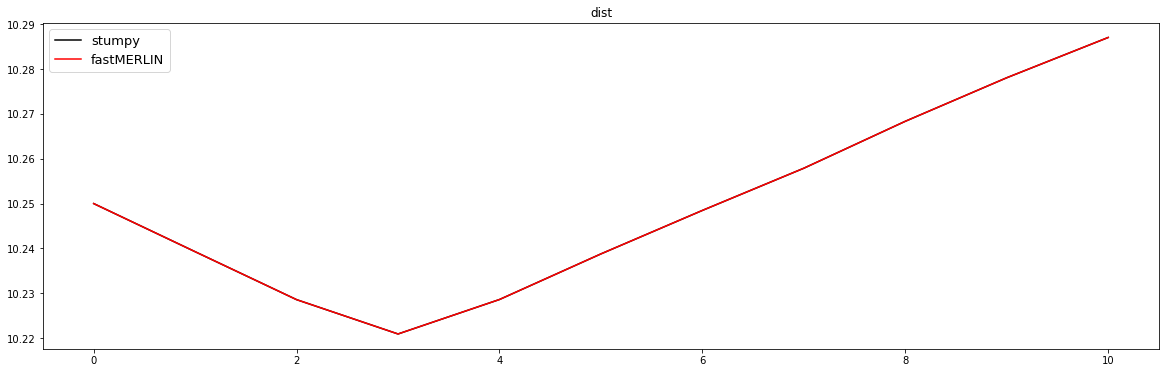

ts:  ts_taxi

> stumpy: 
L=5>>>L=6>>>L=7>>>L=8>>>L=9>>>L=10>>>L=11>>>L=12>>>L=13>>>L=14>>>L=15>>>
> fastMERLN: 
---
>>> L: 5
.....ATTEMPT: #0: USING min_dist: 4.898979485566356.....
#phase I: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
6-th block out of 8
7-th block out of 8
#pahse II: start!
0-th block out of 8
#phase III: start!
end of three-phase process!
.....ATTEMPT: #1: USING min_dist: 2.449489742783178.....
#phase I: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
6-th block out of 8
7-th block out of 8
#pahse II: start!
0-th block out of 8
#phase III: start!
end of three-phase process!
.....ATTEMPT: #2: USING min_dist: 1.224744871391589.....
#phase I: start!
0-th block out of 8
1-th block out of 8
2-th block out of 8
3-th block out of 8
4-th block out of 8
5-th block out of 8
6-th block out of 8
7-th block out of 8
#pa

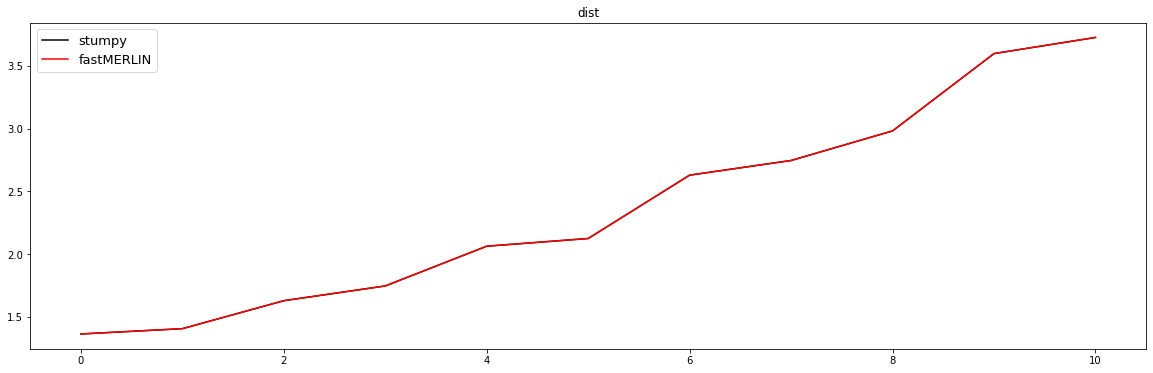

ts:  ts_lab

> stumpy: 
L=100>>>L=101>>>L=102>>>L=103>>>L=104>>>L=105>>>L=106>>>L=107>>>L=108>>>L=109>>>L=110>>>
> fastMERLN: 
---
>>> L: 100
.....ATTEMPT: #0: USING min_dist: 20.09975124224178.....
#phase I: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
#phase 

4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th bl

16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
26-th block out of 34
27-th block out of 34
28-th block out of 34
29-th block out of 34
30-th block out of 34
31-th block out of 34
32-th block out of 34
33-th block out of 34
#pahse II: start!
0-th block out of 34
1-th block out of 34
2-th block out of 34
3-th block out of 34
4-th block out of 34
5-th block out of 34
6-th block out of 34
7-th block out of 34
8-th block out of 34
9-th block out of 34
10-th block out of 34
11-th block out of 34
12-th block out of 34
13-th block out of 34
14-th block out of 34
15-th block out of 34
16-th block out of 34
17-th block out of 34
18-th block out of 34
19-th block out of 34
20-th block out of 34
21-th block out of 34
22-th block out of 34
23-th block out of 34
24-th block out of 34
25-th block out of 34
#phase III: start!
0-th 

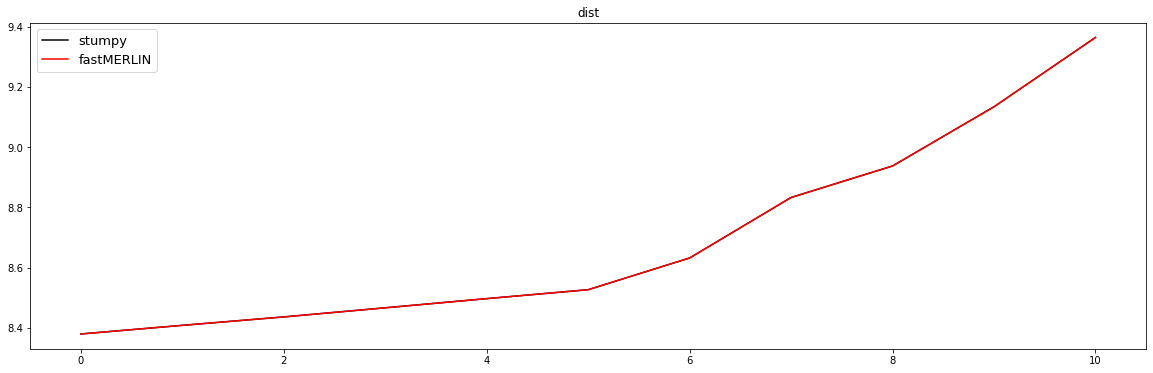

In [196]:
computation_time_dict = {}

for ts_name in ts_names_list:
    print('===================================')
    print('ts: ', ts_name)
    
    computation_time_list = []
    
    ts = ts_short[ts_name]
    minL, maxL = discord_length_choices[ts_name]
    
    #stumpy:
    print('\n> stumpy: ')
    discord_indices_MP, discord_NN_indices_MP, discord_dists_MP, time_MP = discord_finder_MP(ts, minL, maxL)
    computation_time_list.append(np.sum(time_MP))
    
    
    #fastMERLIN:
    print('\n> fastMERLN: ')
    discord_indices, discord_NN_indices, discord_dists, discord_times, discord_misses = fastMERLIN(ts, minL, maxL)
    computation_time_list.append(np.sum(discord_times))
    
    if np.sum(np.abs(discord_indices - discord_indices_MP)) != 0:
        raise ValueError("different discord indices")
        
    plt.figure()
    plt.title('dist')
    plt.plot(discord_dists_MP, c='k', label='stumpy')
    plt.plot(discord_dists, c='r', label='fastMERLIN')
    plt.legend(fontsize=13)
    plt.show()
    
    if len(np.where(np.abs(discord_dists - discord_dists_MP) > 1e-6)[0]) > 0 :
        raise ValueError("different discord dists using fastMERLIN and STUMPY")
    
    if np.sum(np.abs(discord_NN_indices - discord_NN_indices_MP)) != 0:
        raise ValueError("different discord indices")
    
    computation_time_dict[ts_name] = computation_time_list

In [198]:
#comparing perfomance of stumpy (first column) and fastMERLIN (second column) 
#...on short time series

df = pd.DataFrame(computation_time_dict)
df.index = ['stumpy', 'fastMERLIN'] 
df

ts_sine   ts_taxi    ts_lab
stumpy      0.125662  0.111702  1.520932
fastMERLIN  1.199791  0.531579  2.743665

## part-2: compare fastMERLIN and MP on long time series 

ts:  ts_sine

> stumpy: 
L=500>>>L=501>>>L=502>>>L=503>>>L=504>>>L=505>>>L=506>>>L=507>>>L=508>>>L=509>>>L=510>>>
> fastMERLN: 
---
>>> L: 500
.....ATTEMPT: #0: USING min_dist: 44.76605857119878.....
#phase I: start!
0-th block out of 296
1-th block out of 296
2-th block out of 296
3-th block out of 296
4-th block out of 296
5-th block out of 296
6-th block out of 296
7-th block out of 296
8-th block out of 296
9-th block out of 296
10-th block out of 296
11-th block out of 296
12-th block out of 296
13-th block out of 296
14-th block out of 296
15-th block out of 296
16-th block out of 296
17-th block out of 296
18-th block out of 296
19-th block out of 296
20-th block out of 296
21-th block out of 296
22-th block out of 296
23-th block out of 296
24-th block out of 296
25-th block out of 296
26-th block out of 296
27-th block out of 296
28-th block out of 296
29-th block out of 296
30-th block out of 296
31-th block out of 296
32-th block out of 296
33-th block out of 296
34-th block

59-th block out of 296
60-th block out of 296
61-th block out of 296
62-th block out of 296
63-th block out of 296
64-th block out of 296
65-th block out of 296
66-th block out of 296
67-th block out of 296
68-th block out of 296
69-th block out of 296
70-th block out of 296
71-th block out of 296
72-th block out of 296
73-th block out of 296
74-th block out of 296
75-th block out of 296
76-th block out of 296
77-th block out of 296
78-th block out of 296
79-th block out of 296
80-th block out of 296
81-th block out of 296
82-th block out of 296
83-th block out of 296
84-th block out of 296
85-th block out of 296
86-th block out of 296
87-th block out of 296
88-th block out of 296
89-th block out of 296
90-th block out of 296
91-th block out of 296
92-th block out of 296
93-th block out of 296
94-th block out of 296
95-th block out of 296
96-th block out of 296
97-th block out of 296
98-th block out of 296
99-th block out of 296
100-th block out of 296
101-th block out of 296
102-th bl

117-th block out of 296
118-th block out of 296
119-th block out of 296
120-th block out of 296
121-th block out of 296
122-th block out of 296
123-th block out of 296
124-th block out of 296
125-th block out of 296
126-th block out of 296
127-th block out of 296
128-th block out of 296
129-th block out of 296
130-th block out of 296
131-th block out of 296
132-th block out of 296
133-th block out of 296
134-th block out of 296
135-th block out of 296
136-th block out of 296
137-th block out of 296
138-th block out of 296
139-th block out of 296
140-th block out of 296
141-th block out of 296
142-th block out of 296
143-th block out of 296
144-th block out of 296
145-th block out of 296
146-th block out of 296
147-th block out of 296
148-th block out of 296
149-th block out of 296
150-th block out of 296
151-th block out of 296
152-th block out of 296
153-th block out of 296
154-th block out of 296
155-th block out of 296
156-th block out of 296
157-th block out of 296
158-th block out

161-th block out of 296
162-th block out of 296
163-th block out of 296
164-th block out of 296
165-th block out of 296
166-th block out of 296
167-th block out of 296
168-th block out of 296
169-th block out of 296
170-th block out of 296
171-th block out of 296
172-th block out of 296
173-th block out of 296
174-th block out of 296
175-th block out of 296
176-th block out of 296
177-th block out of 296
178-th block out of 296
179-th block out of 296
180-th block out of 296
181-th block out of 296
182-th block out of 296
183-th block out of 296
184-th block out of 296
185-th block out of 296
186-th block out of 296
187-th block out of 296
188-th block out of 296
189-th block out of 296
190-th block out of 296
191-th block out of 296
192-th block out of 296
193-th block out of 296
194-th block out of 296
195-th block out of 296
196-th block out of 296
197-th block out of 296
198-th block out of 296
199-th block out of 296
200-th block out of 296
201-th block out of 296
202-th block out

67-th block out of 296
68-th block out of 296
69-th block out of 296
70-th block out of 296
71-th block out of 296
72-th block out of 296
73-th block out of 296
74-th block out of 296
75-th block out of 296
76-th block out of 296
77-th block out of 296
78-th block out of 296
79-th block out of 296
80-th block out of 296
81-th block out of 296
82-th block out of 296
83-th block out of 296
84-th block out of 296
85-th block out of 296
86-th block out of 296
87-th block out of 296
88-th block out of 296
89-th block out of 296
90-th block out of 296
91-th block out of 296
92-th block out of 296
93-th block out of 296
94-th block out of 296
95-th block out of 296
96-th block out of 296
97-th block out of 296
98-th block out of 296
99-th block out of 296
100-th block out of 296
101-th block out of 296
102-th block out of 296
103-th block out of 296
104-th block out of 296
105-th block out of 296
106-th block out of 296
107-th block out of 296
108-th block out of 296
109-th block out of 296
1

154-th block out of 296
155-th block out of 296
156-th block out of 296
157-th block out of 296
158-th block out of 296
159-th block out of 296
160-th block out of 296
161-th block out of 296
162-th block out of 296
163-th block out of 296
164-th block out of 296
165-th block out of 296
166-th block out of 296
167-th block out of 296
168-th block out of 296
169-th block out of 296
170-th block out of 296
171-th block out of 296
172-th block out of 296
173-th block out of 296
174-th block out of 296
175-th block out of 296
176-th block out of 296
177-th block out of 296
178-th block out of 296
179-th block out of 296
180-th block out of 296
181-th block out of 296
182-th block out of 296
183-th block out of 296
184-th block out of 296
185-th block out of 296
186-th block out of 296
187-th block out of 296
188-th block out of 296
189-th block out of 296
190-th block out of 296
191-th block out of 296
192-th block out of 296
193-th block out of 296
194-th block out of 296
195-th block out

111-th block out of 296
112-th block out of 296
113-th block out of 296
114-th block out of 296
115-th block out of 296
116-th block out of 296
117-th block out of 296
118-th block out of 296
119-th block out of 296
120-th block out of 296
121-th block out of 296
122-th block out of 296
123-th block out of 296
124-th block out of 296
125-th block out of 296
126-th block out of 296
127-th block out of 296
128-th block out of 296
129-th block out of 296
130-th block out of 296
131-th block out of 296
132-th block out of 296
133-th block out of 296
134-th block out of 296
135-th block out of 296
136-th block out of 296
137-th block out of 296
138-th block out of 296
139-th block out of 296
140-th block out of 296
141-th block out of 296
142-th block out of 296
143-th block out of 296
144-th block out of 296
145-th block out of 296
146-th block out of 296
147-th block out of 296
148-th block out of 296
149-th block out of 296
150-th block out of 296
151-th block out of 296
152-th block out

CASE L=501: computation time: 5.164191722869873 sec
---
>>> L: 502
.....ATTEMPT: #0: USING min_dist: 10.239262719680418.....
#phase I: start!
0-th block out of 296
1-th block out of 296
2-th block out of 296
3-th block out of 296
4-th block out of 296
5-th block out of 296
6-th block out of 296
7-th block out of 296
8-th block out of 296
9-th block out of 296
10-th block out of 296
11-th block out of 296
12-th block out of 296
13-th block out of 296
14-th block out of 296
15-th block out of 296
16-th block out of 296
17-th block out of 296
18-th block out of 296
19-th block out of 296
20-th block out of 296
21-th block out of 296
22-th block out of 296
23-th block out of 296
24-th block out of 296
25-th block out of 296
26-th block out of 296
27-th block out of 296
28-th block out of 296
29-th block out of 296
30-th block out of 296
31-th block out of 296
32-th block out of 296
33-th block out of 296
34-th block out of 296
35-th block out of 296
36-th block out of 296
37-th block out o

142-th block out of 296
143-th block out of 296
144-th block out of 296
145-th block out of 296
#phase III: start!
end of three-phase process!
.....ATTEMPT: #1: USING min_dist: 10.218865781991813.....
#phase I: start!
0-th block out of 296
1-th block out of 296
2-th block out of 296
3-th block out of 296
4-th block out of 296
5-th block out of 296
6-th block out of 296
7-th block out of 296
8-th block out of 296
9-th block out of 296
10-th block out of 296
11-th block out of 296
12-th block out of 296
13-th block out of 296
14-th block out of 296
15-th block out of 296
16-th block out of 296
17-th block out of 296
18-th block out of 296
19-th block out of 296
20-th block out of 296
21-th block out of 296
22-th block out of 296
23-th block out of 296
24-th block out of 296
25-th block out of 296
26-th block out of 296
27-th block out of 296
28-th block out of 296
29-th block out of 296
30-th block out of 296
31-th block out of 296
32-th block out of 296
33-th block out of 296
34-th bloc

CASE L=502: computation time: 4.823103189468384 sec
---
>>> L: 503
.....ATTEMPT: #0: USING min_dist: 10.228567284411163.....
#phase I: start!
0-th block out of 296
1-th block out of 296
2-th block out of 296
3-th block out of 296
4-th block out of 296
5-th block out of 296
6-th block out of 296
7-th block out of 296
8-th block out of 296
9-th block out of 296
10-th block out of 296
11-th block out of 296
12-th block out of 296
13-th block out of 296
14-th block out of 296
15-th block out of 296
16-th block out of 296
17-th block out of 296
18-th block out of 296
19-th block out of 296
20-th block out of 296
21-th block out of 296
22-th block out of 296
23-th block out of 296
24-th block out of 296
25-th block out of 296
26-th block out of 296
27-th block out of 296
28-th block out of 296
29-th block out of 296
30-th block out of 296
31-th block out of 296
32-th block out of 296
33-th block out of 296
34-th block out of 296
35-th block out of 296
36-th block out of 296
37-th block out o

#phase I: start!
0-th block out of 296
1-th block out of 296
2-th block out of 296
3-th block out of 296
4-th block out of 296
5-th block out of 296
6-th block out of 296
7-th block out of 296
8-th block out of 296
9-th block out of 296
10-th block out of 296
11-th block out of 296
12-th block out of 296
13-th block out of 296
14-th block out of 296
15-th block out of 296
16-th block out of 296
17-th block out of 296
18-th block out of 296
19-th block out of 296
20-th block out of 296
21-th block out of 296
22-th block out of 296
23-th block out of 296
24-th block out of 296
25-th block out of 296
26-th block out of 296
27-th block out of 296
28-th block out of 296
29-th block out of 296
30-th block out of 296
31-th block out of 296
32-th block out of 296
33-th block out of 296
34-th block out of 296
35-th block out of 296
36-th block out of 296
37-th block out of 296
38-th block out of 296
39-th block out of 296
40-th block out of 296
41-th block out of 296
42-th block out of 296
43-t

24-th block out of 296
25-th block out of 296
26-th block out of 296
27-th block out of 296
28-th block out of 296
29-th block out of 296
30-th block out of 296
31-th block out of 296
32-th block out of 296
33-th block out of 296
34-th block out of 296
35-th block out of 296
36-th block out of 296
37-th block out of 296
38-th block out of 296
39-th block out of 296
40-th block out of 296
41-th block out of 296
42-th block out of 296
43-th block out of 296
44-th block out of 296
45-th block out of 296
46-th block out of 296
47-th block out of 296
48-th block out of 296
49-th block out of 296
50-th block out of 296
51-th block out of 296
52-th block out of 296
53-th block out of 296
54-th block out of 296
55-th block out of 296
56-th block out of 296
57-th block out of 296
58-th block out of 296
59-th block out of 296
60-th block out of 296
61-th block out of 296
62-th block out of 296
63-th block out of 296
64-th block out of 296
65-th block out of 296
66-th block out of 296
67-th block

109-th block out of 296
110-th block out of 296
111-th block out of 296
112-th block out of 296
113-th block out of 296
114-th block out of 296
115-th block out of 296
116-th block out of 296
117-th block out of 296
118-th block out of 296
119-th block out of 296
120-th block out of 296
121-th block out of 296
122-th block out of 296
123-th block out of 296
124-th block out of 296
125-th block out of 296
126-th block out of 296
127-th block out of 296
128-th block out of 296
129-th block out of 296
130-th block out of 296
131-th block out of 296
132-th block out of 296
133-th block out of 296
134-th block out of 296
135-th block out of 296
136-th block out of 296
137-th block out of 296
138-th block out of 296
139-th block out of 296
140-th block out of 296
141-th block out of 296
142-th block out of 296
143-th block out of 296
144-th block out of 296
145-th block out of 296
146-th block out of 296
147-th block out of 296
148-th block out of 296
149-th block out of 296
150-th block out

#phase I: start!
0-th block out of 296
1-th block out of 296
2-th block out of 296
3-th block out of 296
4-th block out of 296
5-th block out of 296
6-th block out of 296
7-th block out of 296
8-th block out of 296
9-th block out of 296
10-th block out of 296
11-th block out of 296
12-th block out of 296
13-th block out of 296
14-th block out of 296
15-th block out of 296
16-th block out of 296
17-th block out of 296
18-th block out of 296
19-th block out of 296
20-th block out of 296
21-th block out of 296
22-th block out of 296
23-th block out of 296
24-th block out of 296
25-th block out of 296
26-th block out of 296
27-th block out of 296
28-th block out of 296
29-th block out of 296
30-th block out of 296
31-th block out of 296
32-th block out of 296
33-th block out of 296
34-th block out of 296
35-th block out of 296
36-th block out of 296
37-th block out of 296
38-th block out of 296
39-th block out of 296
40-th block out of 296
41-th block out of 296
42-th block out of 296
43-t

117-th block out of 296
118-th block out of 296
119-th block out of 296
120-th block out of 296
121-th block out of 296
122-th block out of 296
123-th block out of 296
124-th block out of 296
125-th block out of 296
126-th block out of 296
127-th block out of 296
128-th block out of 296
129-th block out of 296
130-th block out of 296
131-th block out of 296
132-th block out of 296
133-th block out of 296
134-th block out of 296
135-th block out of 296
136-th block out of 296
137-th block out of 296
138-th block out of 296
139-th block out of 296
140-th block out of 296
141-th block out of 296
142-th block out of 296
143-th block out of 296
144-th block out of 296
145-th block out of 296
146-th block out of 296
#phase III: start!
0-th block out of 296
1-th block out of 296
2-th block out of 296
3-th block out of 296
4-th block out of 296
5-th block out of 296
6-th block out of 296
7-th block out of 296
8-th block out of 296
9-th block out of 296
10-th block out of 296
11-th block out of

49-th block out of 296
50-th block out of 296
51-th block out of 296
52-th block out of 296
53-th block out of 296
54-th block out of 296
55-th block out of 296
56-th block out of 296
57-th block out of 296
58-th block out of 296
59-th block out of 296
60-th block out of 296
61-th block out of 296
62-th block out of 296
63-th block out of 296
64-th block out of 296
65-th block out of 296
66-th block out of 296
67-th block out of 296
68-th block out of 296
69-th block out of 296
70-th block out of 296
71-th block out of 296
72-th block out of 296
73-th block out of 296
74-th block out of 296
75-th block out of 296
76-th block out of 296
77-th block out of 296
78-th block out of 296
79-th block out of 296
80-th block out of 296
81-th block out of 296
82-th block out of 296
83-th block out of 296
84-th block out of 296
85-th block out of 296
86-th block out of 296
87-th block out of 296
88-th block out of 296
89-th block out of 296
90-th block out of 296
91-th block out of 296
92-th block

#phase I: start!
0-th block out of 296
1-th block out of 296
2-th block out of 296
3-th block out of 296
4-th block out of 296
5-th block out of 296
6-th block out of 296
7-th block out of 296
8-th block out of 296
9-th block out of 296
10-th block out of 296
11-th block out of 296
12-th block out of 296
13-th block out of 296
14-th block out of 296
15-th block out of 296
16-th block out of 296
17-th block out of 296
18-th block out of 296
19-th block out of 296
20-th block out of 296
21-th block out of 296
22-th block out of 296
23-th block out of 296
24-th block out of 296
25-th block out of 296
26-th block out of 296
27-th block out of 296
28-th block out of 296
29-th block out of 296
30-th block out of 296
31-th block out of 296
32-th block out of 296
33-th block out of 296
34-th block out of 296
35-th block out of 296
36-th block out of 296
37-th block out of 296
38-th block out of 296
39-th block out of 296
40-th block out of 296
41-th block out of 296
42-th block out of 296
43-t

50-th block out of 296
51-th block out of 296
52-th block out of 296
53-th block out of 296
54-th block out of 296
55-th block out of 296
56-th block out of 296
57-th block out of 296
58-th block out of 296
59-th block out of 296
60-th block out of 296
61-th block out of 296
62-th block out of 296
63-th block out of 296
64-th block out of 296
65-th block out of 296
66-th block out of 296
67-th block out of 296
68-th block out of 296
69-th block out of 296
70-th block out of 296
71-th block out of 296
72-th block out of 296
73-th block out of 296
74-th block out of 296
75-th block out of 296
76-th block out of 296
77-th block out of 296
78-th block out of 296
79-th block out of 296
80-th block out of 296
81-th block out of 296
82-th block out of 296
83-th block out of 296
84-th block out of 296
85-th block out of 296
86-th block out of 296
87-th block out of 296
88-th block out of 296
89-th block out of 296
90-th block out of 296
91-th block out of 296
92-th block out of 296
93-th block

156-th block out of 296
157-th block out of 296
158-th block out of 296
159-th block out of 296
160-th block out of 296
161-th block out of 296
162-th block out of 296
163-th block out of 296
164-th block out of 296
165-th block out of 296
166-th block out of 296
167-th block out of 296
168-th block out of 296
169-th block out of 296
170-th block out of 296
171-th block out of 296
172-th block out of 296
173-th block out of 296
174-th block out of 296
175-th block out of 296
176-th block out of 296
177-th block out of 296
178-th block out of 296
179-th block out of 296
180-th block out of 296
181-th block out of 296
182-th block out of 296
183-th block out of 296
184-th block out of 296
185-th block out of 296
186-th block out of 296
187-th block out of 296
188-th block out of 296
189-th block out of 296
190-th block out of 296
191-th block out of 296
192-th block out of 296
193-th block out of 296
194-th block out of 296
195-th block out of 296
196-th block out of 296
197-th block out

#phase I: start!
0-th block out of 296
1-th block out of 296
2-th block out of 296
3-th block out of 296
4-th block out of 296
5-th block out of 296
6-th block out of 296
7-th block out of 296
8-th block out of 296
9-th block out of 296
10-th block out of 296
11-th block out of 296
12-th block out of 296
13-th block out of 296
14-th block out of 296
15-th block out of 296
16-th block out of 296
17-th block out of 296
18-th block out of 296
19-th block out of 296
20-th block out of 296
21-th block out of 296
22-th block out of 296
23-th block out of 296
24-th block out of 296
25-th block out of 296
26-th block out of 296
27-th block out of 296
28-th block out of 296
29-th block out of 296
30-th block out of 296
31-th block out of 296
32-th block out of 296
33-th block out of 296
34-th block out of 296
35-th block out of 296
36-th block out of 296
37-th block out of 296
38-th block out of 296
39-th block out of 296
40-th block out of 296
41-th block out of 296
42-th block out of 296
43-t

67-th block out of 296
68-th block out of 296
69-th block out of 296
70-th block out of 296
71-th block out of 296
72-th block out of 296
73-th block out of 296
74-th block out of 296
75-th block out of 296
76-th block out of 296
77-th block out of 296
78-th block out of 296
79-th block out of 296
80-th block out of 296
81-th block out of 296
82-th block out of 296
83-th block out of 296
84-th block out of 296
85-th block out of 296
86-th block out of 296
87-th block out of 296
88-th block out of 296
89-th block out of 296
90-th block out of 296
91-th block out of 296
92-th block out of 296
93-th block out of 296
94-th block out of 296
95-th block out of 296
96-th block out of 296
97-th block out of 296
98-th block out of 296
99-th block out of 296
100-th block out of 296
101-th block out of 296
102-th block out of 296
103-th block out of 296
104-th block out of 296
105-th block out of 296
106-th block out of 296
107-th block out of 296
108-th block out of 296
109-th block out of 296
1

126-th block out of 296
127-th block out of 296
128-th block out of 296
129-th block out of 296
130-th block out of 296
131-th block out of 296
132-th block out of 296
133-th block out of 296
134-th block out of 296
135-th block out of 296
136-th block out of 296
137-th block out of 296
138-th block out of 296
139-th block out of 296
140-th block out of 296
141-th block out of 296
142-th block out of 296
143-th block out of 296
144-th block out of 296
145-th block out of 296
146-th block out of 296
147-th block out of 296
148-th block out of 296
149-th block out of 296
150-th block out of 296
151-th block out of 296
152-th block out of 296
153-th block out of 296
154-th block out of 296
155-th block out of 296
156-th block out of 296
157-th block out of 296
158-th block out of 296
159-th block out of 296
160-th block out of 296
161-th block out of 296
162-th block out of 296
163-th block out of 296
164-th block out of 296
165-th block out of 296
166-th block out of 296
167-th block out

223-th block out of 296
224-th block out of 296
225-th block out of 296
226-th block out of 296
227-th block out of 296
228-th block out of 296
229-th block out of 296
230-th block out of 296
231-th block out of 296
232-th block out of 296
233-th block out of 296
234-th block out of 296
235-th block out of 296
236-th block out of 296
237-th block out of 296
238-th block out of 296
239-th block out of 296
240-th block out of 296
241-th block out of 296
242-th block out of 296
243-th block out of 296
244-th block out of 296
245-th block out of 296
246-th block out of 296
247-th block out of 296
248-th block out of 296
249-th block out of 296
250-th block out of 296
251-th block out of 296
252-th block out of 296
253-th block out of 296
254-th block out of 296
255-th block out of 296
256-th block out of 296
257-th block out of 296
258-th block out of 296
259-th block out of 296
260-th block out of 296
261-th block out of 296
262-th block out of 296
263-th block out of 296
264-th block out

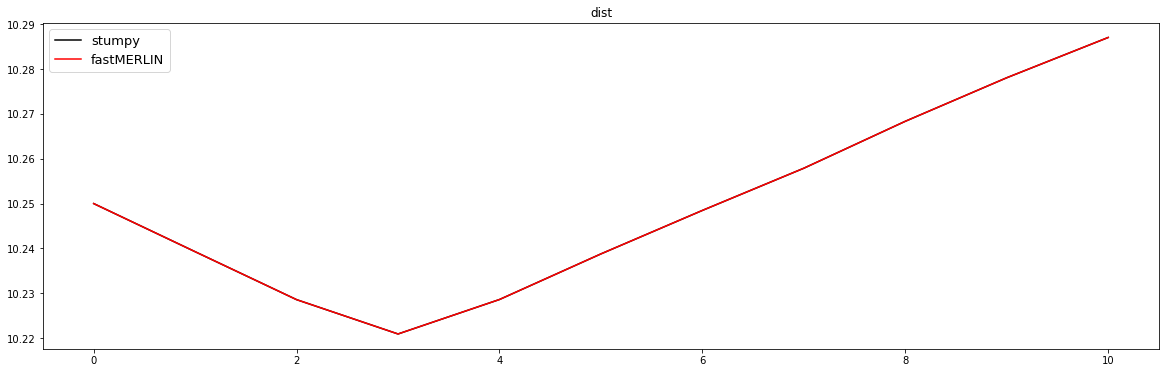

ts:  ts_taxi

> stumpy: 
L=5>>>L=6>>>L=7>>>L=8>>>L=9>>>L=10>>>L=11>>>L=12>>>L=13>>>L=14>>>L=15>>>
> fastMERLN: 
---
>>> L: 5
.....ATTEMPT: #0: USING min_dist: 4.898979485566356.....
#phase I: start!
0-th block out of 261
1-th block out of 261
2-th block out of 261
3-th block out of 261
4-th block out of 261
5-th block out of 261
6-th block out of 261
7-th block out of 261
8-th block out of 261
9-th block out of 261
10-th block out of 261
11-th block out of 261
12-th block out of 261
13-th block out of 261
14-th block out of 261
15-th block out of 261
16-th block out of 261
17-th block out of 261
18-th block out of 261
19-th block out of 261
20-th block out of 261
21-th block out of 261
22-th block out of 261
23-th block out of 261
24-th block out of 261
25-th block out of 261
26-th block out of 261
27-th block out of 261
28-th block out of 261
29-th block out of 261
30-th block out of 261
31-th block out of 261
32-th block out of 261
33-th block out of 261
34-th block out of 261
35-th 

102-th block out of 261
103-th block out of 261
104-th block out of 261
105-th block out of 261
106-th block out of 261
107-th block out of 261
108-th block out of 261
109-th block out of 261
110-th block out of 261
111-th block out of 261
112-th block out of 261
113-th block out of 261
114-th block out of 261
115-th block out of 261
116-th block out of 261
117-th block out of 261
118-th block out of 261
119-th block out of 261
120-th block out of 261
121-th block out of 261
122-th block out of 261
123-th block out of 261
124-th block out of 261
125-th block out of 261
126-th block out of 261
127-th block out of 261
128-th block out of 261
129-th block out of 261
130-th block out of 261
131-th block out of 261
132-th block out of 261
133-th block out of 261
134-th block out of 261
135-th block out of 261
136-th block out of 261
137-th block out of 261
138-th block out of 261
139-th block out of 261
140-th block out of 261
141-th block out of 261
142-th block out of 261
143-th block out

211-th block out of 261
212-th block out of 261
213-th block out of 261
214-th block out of 261
215-th block out of 261
216-th block out of 261
217-th block out of 261
218-th block out of 261
219-th block out of 261
220-th block out of 261
221-th block out of 261
222-th block out of 261
223-th block out of 261
224-th block out of 261
225-th block out of 261
226-th block out of 261
227-th block out of 261
228-th block out of 261
229-th block out of 261
230-th block out of 261
231-th block out of 261
232-th block out of 261
233-th block out of 261
234-th block out of 261
235-th block out of 261
236-th block out of 261
237-th block out of 261
238-th block out of 261
239-th block out of 261
240-th block out of 261
241-th block out of 261
242-th block out of 261
243-th block out of 261
244-th block out of 261
245-th block out of 261
246-th block out of 261
247-th block out of 261
248-th block out of 261
249-th block out of 261
250-th block out of 261
251-th block out of 261
252-th block out

34-th block out of 261
35-th block out of 261
36-th block out of 261
37-th block out of 261
38-th block out of 261
39-th block out of 261
40-th block out of 261
41-th block out of 261
42-th block out of 261
43-th block out of 261
44-th block out of 261
45-th block out of 261
46-th block out of 261
47-th block out of 261
48-th block out of 261
49-th block out of 261
50-th block out of 261
51-th block out of 261
52-th block out of 261
53-th block out of 261
54-th block out of 261
55-th block out of 261
56-th block out of 261
57-th block out of 261
58-th block out of 261
59-th block out of 261
60-th block out of 261
61-th block out of 261
62-th block out of 261
63-th block out of 261
64-th block out of 261
65-th block out of 261
66-th block out of 261
67-th block out of 261
68-th block out of 261
69-th block out of 261
70-th block out of 261
71-th block out of 261
72-th block out of 261
73-th block out of 261
74-th block out of 261
75-th block out of 261
76-th block out of 261
77-th block

25-th block out of 261
26-th block out of 261
27-th block out of 261
28-th block out of 261
29-th block out of 261
30-th block out of 261
31-th block out of 261
32-th block out of 261
33-th block out of 261
34-th block out of 261
35-th block out of 261
36-th block out of 261
37-th block out of 261
38-th block out of 261
39-th block out of 261
40-th block out of 261
41-th block out of 261
42-th block out of 261
43-th block out of 261
44-th block out of 261
45-th block out of 261
46-th block out of 261
47-th block out of 261
48-th block out of 261
49-th block out of 261
50-th block out of 261
51-th block out of 261
52-th block out of 261
53-th block out of 261
54-th block out of 261
55-th block out of 261
56-th block out of 261
57-th block out of 261
58-th block out of 261
59-th block out of 261
60-th block out of 261
61-th block out of 261
62-th block out of 261
63-th block out of 261
64-th block out of 261
65-th block out of 261
66-th block out of 261
67-th block out of 261
68-th block

183-th block out of 261
184-th block out of 261
185-th block out of 261
186-th block out of 261
187-th block out of 261
188-th block out of 261
189-th block out of 261
190-th block out of 261
191-th block out of 261
192-th block out of 261
193-th block out of 261
194-th block out of 261
195-th block out of 261
196-th block out of 261
197-th block out of 261
198-th block out of 261
199-th block out of 261
200-th block out of 261
201-th block out of 261
202-th block out of 261
203-th block out of 261
204-th block out of 261
205-th block out of 261
206-th block out of 261
207-th block out of 261
208-th block out of 261
209-th block out of 261
210-th block out of 261
211-th block out of 261
212-th block out of 261
213-th block out of 261
214-th block out of 261
215-th block out of 261
216-th block out of 261
217-th block out of 261
218-th block out of 261
219-th block out of 261
220-th block out of 261
221-th block out of 261
222-th block out of 261
223-th block out of 261
224-th block out

9-th block out of 261
10-th block out of 261
11-th block out of 261
12-th block out of 261
13-th block out of 261
14-th block out of 261
15-th block out of 261
16-th block out of 261
17-th block out of 261
18-th block out of 261
19-th block out of 261
20-th block out of 261
21-th block out of 261
22-th block out of 261
23-th block out of 261
24-th block out of 261
25-th block out of 261
26-th block out of 261
27-th block out of 261
28-th block out of 261
29-th block out of 261
30-th block out of 261
31-th block out of 261
32-th block out of 261
33-th block out of 261
34-th block out of 261
35-th block out of 261
36-th block out of 261
37-th block out of 261
38-th block out of 261
39-th block out of 261
40-th block out of 261
41-th block out of 261
42-th block out of 261
43-th block out of 261
44-th block out of 261
45-th block out of 261
46-th block out of 261
47-th block out of 261
48-th block out of 261
49-th block out of 261
50-th block out of 261
51-th block out of 261
52-th block 

117-th block out of 261
118-th block out of 261
119-th block out of 261
120-th block out of 261
121-th block out of 261
122-th block out of 261
123-th block out of 261
124-th block out of 261
125-th block out of 261
126-th block out of 261
127-th block out of 261
128-th block out of 261
129-th block out of 261
130-th block out of 261
131-th block out of 261
132-th block out of 261
133-th block out of 261
134-th block out of 261
135-th block out of 261
136-th block out of 261
137-th block out of 261
138-th block out of 261
139-th block out of 261
140-th block out of 261
141-th block out of 261
142-th block out of 261
143-th block out of 261
144-th block out of 261
145-th block out of 261
146-th block out of 261
147-th block out of 261
148-th block out of 261
149-th block out of 261
150-th block out of 261
151-th block out of 261
152-th block out of 261
153-th block out of 261
154-th block out of 261
155-th block out of 261
156-th block out of 261
157-th block out of 261
158-th block out

#phase I: start!
0-th block out of 261
1-th block out of 261
2-th block out of 261
3-th block out of 261
4-th block out of 261
5-th block out of 261
6-th block out of 261
7-th block out of 261
8-th block out of 261
9-th block out of 261
10-th block out of 261
11-th block out of 261
12-th block out of 261
13-th block out of 261
14-th block out of 261
15-th block out of 261
16-th block out of 261
17-th block out of 261
18-th block out of 261
19-th block out of 261
20-th block out of 261
21-th block out of 261
22-th block out of 261
23-th block out of 261
24-th block out of 261
25-th block out of 261
26-th block out of 261
27-th block out of 261
28-th block out of 261
29-th block out of 261
30-th block out of 261
31-th block out of 261
32-th block out of 261
33-th block out of 261
34-th block out of 261
35-th block out of 261
36-th block out of 261
37-th block out of 261
38-th block out of 261
39-th block out of 261
40-th block out of 261
41-th block out of 261
42-th block out of 261
43-t

149-th block out of 261
150-th block out of 261
151-th block out of 261
152-th block out of 261
153-th block out of 261
154-th block out of 261
155-th block out of 261
156-th block out of 261
157-th block out of 261
158-th block out of 261
159-th block out of 261
160-th block out of 261
161-th block out of 261
162-th block out of 261
163-th block out of 261
164-th block out of 261
165-th block out of 261
166-th block out of 261
167-th block out of 261
168-th block out of 261
169-th block out of 261
170-th block out of 261
171-th block out of 261
172-th block out of 261
173-th block out of 261
174-th block out of 261
175-th block out of 261
176-th block out of 261
177-th block out of 261
178-th block out of 261
179-th block out of 261
180-th block out of 261
181-th block out of 261
182-th block out of 261
183-th block out of 261
184-th block out of 261
185-th block out of 261
186-th block out of 261
187-th block out of 261
188-th block out of 261
189-th block out of 261
190-th block out

240-th block out of 261
241-th block out of 261
242-th block out of 261
243-th block out of 261
244-th block out of 261
245-th block out of 261
246-th block out of 261
247-th block out of 261
248-th block out of 261
249-th block out of 261
250-th block out of 261
251-th block out of 261
252-th block out of 261
253-th block out of 261
254-th block out of 261
255-th block out of 261
256-th block out of 261
257-th block out of 261
258-th block out of 261
259-th block out of 261
260-th block out of 261
#pahse II: start!
0-th block out of 261
1-th block out of 261
2-th block out of 261
3-th block out of 261
4-th block out of 261
5-th block out of 261
6-th block out of 261
7-th block out of 261
8-th block out of 261
9-th block out of 261
10-th block out of 261
11-th block out of 261
12-th block out of 261
13-th block out of 261
14-th block out of 261
15-th block out of 261
16-th block out of 261
17-th block out of 261
18-th block out of 261
19-th block out of 261
20-th block out of 261
21-th

#phase I: start!
0-th block out of 261
1-th block out of 261
2-th block out of 261
3-th block out of 261
4-th block out of 261
5-th block out of 261
6-th block out of 261
7-th block out of 261
8-th block out of 261
9-th block out of 261
10-th block out of 261
11-th block out of 261
12-th block out of 261
13-th block out of 261
14-th block out of 261
15-th block out of 261
16-th block out of 261
17-th block out of 261
18-th block out of 261
19-th block out of 261
20-th block out of 261
21-th block out of 261
22-th block out of 261
23-th block out of 261
24-th block out of 261
25-th block out of 261
26-th block out of 261
27-th block out of 261
28-th block out of 261
29-th block out of 261
30-th block out of 261
31-th block out of 261
32-th block out of 261
33-th block out of 261
34-th block out of 261
35-th block out of 261
36-th block out of 261
37-th block out of 261
38-th block out of 261
39-th block out of 261
40-th block out of 261
41-th block out of 261
42-th block out of 261
43-t

#phase I: start!
0-th block out of 261
1-th block out of 261
2-th block out of 261
3-th block out of 261
4-th block out of 261
5-th block out of 261
6-th block out of 261
7-th block out of 261
8-th block out of 261
9-th block out of 261
10-th block out of 261
11-th block out of 261
12-th block out of 261
13-th block out of 261
14-th block out of 261
15-th block out of 261
16-th block out of 261
17-th block out of 261
18-th block out of 261
19-th block out of 261
20-th block out of 261
21-th block out of 261
22-th block out of 261
23-th block out of 261
24-th block out of 261
25-th block out of 261
26-th block out of 261
27-th block out of 261
28-th block out of 261
29-th block out of 261
30-th block out of 261
31-th block out of 261
32-th block out of 261
33-th block out of 261
34-th block out of 261
35-th block out of 261
36-th block out of 261
37-th block out of 261
38-th block out of 261
39-th block out of 261
40-th block out of 261
41-th block out of 261
42-th block out of 261
43-t

#phase I: start!
0-th block out of 261
1-th block out of 261
2-th block out of 261
3-th block out of 261
4-th block out of 261
5-th block out of 261
6-th block out of 261
7-th block out of 261
8-th block out of 261
9-th block out of 261
10-th block out of 261
11-th block out of 261
12-th block out of 261
13-th block out of 261
14-th block out of 261
15-th block out of 261
16-th block out of 261
17-th block out of 261
18-th block out of 261
19-th block out of 261
20-th block out of 261
21-th block out of 261
22-th block out of 261
23-th block out of 261
24-th block out of 261
25-th block out of 261
26-th block out of 261
27-th block out of 261
28-th block out of 261
29-th block out of 261
30-th block out of 261
31-th block out of 261
32-th block out of 261
33-th block out of 261
34-th block out of 261
35-th block out of 261
36-th block out of 261
37-th block out of 261
38-th block out of 261
39-th block out of 261
40-th block out of 261
41-th block out of 261
42-th block out of 261
43-t

11-th block out of 261
12-th block out of 261
13-th block out of 261
14-th block out of 261
15-th block out of 261
16-th block out of 261
17-th block out of 261
18-th block out of 261
19-th block out of 261
20-th block out of 261
21-th block out of 261
22-th block out of 261
23-th block out of 261
24-th block out of 261
25-th block out of 261
26-th block out of 261
27-th block out of 261
28-th block out of 261
29-th block out of 261
30-th block out of 261
31-th block out of 261
32-th block out of 261
33-th block out of 261
34-th block out of 261
35-th block out of 261
36-th block out of 261
37-th block out of 261
38-th block out of 261
39-th block out of 261
40-th block out of 261
41-th block out of 261
42-th block out of 261
43-th block out of 261
44-th block out of 261
45-th block out of 261
46-th block out of 261
47-th block out of 261
48-th block out of 261
49-th block out of 261
50-th block out of 261
51-th block out of 261
52-th block out of 261
53-th block out of 261
54-th block

8-th block out of 261
9-th block out of 261
10-th block out of 261
11-th block out of 261
12-th block out of 261
13-th block out of 261
14-th block out of 261
15-th block out of 261
16-th block out of 261
17-th block out of 261
18-th block out of 261
19-th block out of 261
20-th block out of 261
21-th block out of 261
22-th block out of 261
23-th block out of 261
24-th block out of 261
25-th block out of 261
26-th block out of 261
27-th block out of 261
28-th block out of 261
29-th block out of 261
30-th block out of 261
31-th block out of 261
32-th block out of 261
33-th block out of 261
34-th block out of 261
35-th block out of 261
36-th block out of 261
37-th block out of 261
38-th block out of 261
39-th block out of 261
40-th block out of 261
41-th block out of 261
42-th block out of 261
43-th block out of 261
44-th block out of 261
45-th block out of 261
46-th block out of 261
47-th block out of 261
48-th block out of 261
49-th block out of 261
50-th block out of 261
51-th block o

136-th block out of 261
137-th block out of 261
138-th block out of 261
139-th block out of 261
140-th block out of 261
141-th block out of 261
142-th block out of 261
143-th block out of 261
144-th block out of 261
145-th block out of 261
146-th block out of 261
147-th block out of 261
148-th block out of 261
149-th block out of 261
150-th block out of 261
151-th block out of 261
152-th block out of 261
153-th block out of 261
154-th block out of 261
155-th block out of 261
156-th block out of 261
157-th block out of 261
158-th block out of 261
159-th block out of 261
160-th block out of 261
161-th block out of 261
162-th block out of 261
163-th block out of 261
164-th block out of 261
165-th block out of 261
166-th block out of 261
167-th block out of 261
168-th block out of 261
169-th block out of 261
170-th block out of 261
171-th block out of 261
172-th block out of 261
173-th block out of 261
174-th block out of 261
175-th block out of 261
176-th block out of 261
177-th block out

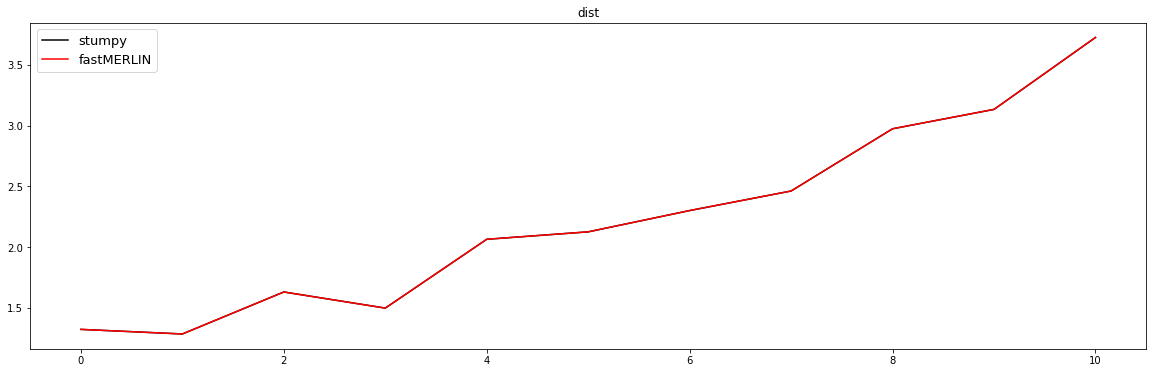

ts:  ts_lab

> stumpy: 
L=100>>>L=101>>>L=102>>>L=103>>>L=104>>>L=105>>>L=106>>>L=107>>>L=108>>>L=109>>>L=110>>>
> fastMERLN: 
---
>>> L: 100
.....ATTEMPT: #0: USING min_dist: 20.09975124224178.....
#phase I: start!
0-th block out of 422
1-th block out of 422
2-th block out of 422
3-th block out of 422
4-th block out of 422
5-th block out of 422
6-th block out of 422
7-th block out of 422
8-th block out of 422
9-th block out of 422
10-th block out of 422
11-th block out of 422
12-th block out of 422
13-th block out of 422
14-th block out of 422
15-th block out of 422
16-th block out of 422
17-th block out of 422
18-th block out of 422
19-th block out of 422
20-th block out of 422
21-th block out of 422
22-th block out of 422
23-th block out of 422
24-th block out of 422
25-th block out of 422
26-th block out of 422
27-th block out of 422
28-th block out of 422
29-th block out of 422
30-th block out of 422
31-th block out of 422
32-th block out of 422
33-th block out of 422
34-th block 

361-th block out of 422
362-th block out of 422
363-th block out of 422
364-th block out of 422
365-th block out of 422
366-th block out of 422
367-th block out of 422
368-th block out of 422
369-th block out of 422
370-th block out of 422
371-th block out of 422
372-th block out of 422
373-th block out of 422
374-th block out of 422
375-th block out of 422
376-th block out of 422
377-th block out of 422
378-th block out of 422
379-th block out of 422
380-th block out of 422
381-th block out of 422
382-th block out of 422
383-th block out of 422
384-th block out of 422
385-th block out of 422
386-th block out of 422
387-th block out of 422
388-th block out of 422
389-th block out of 422
390-th block out of 422
391-th block out of 422
392-th block out of 422
393-th block out of 422
394-th block out of 422
395-th block out of 422
396-th block out of 422
397-th block out of 422
398-th block out of 422
399-th block out of 422
400-th block out of 422
401-th block out of 422
402-th block out

304-th block out of 422
305-th block out of 422
306-th block out of 422
307-th block out of 422
308-th block out of 422
309-th block out of 422
310-th block out of 422
311-th block out of 422
312-th block out of 422
313-th block out of 422
314-th block out of 422
315-th block out of 422
316-th block out of 422
317-th block out of 422
318-th block out of 422
319-th block out of 422
320-th block out of 422
321-th block out of 422
322-th block out of 422
323-th block out of 422
324-th block out of 422
325-th block out of 422
326-th block out of 422
327-th block out of 422
328-th block out of 422
329-th block out of 422
330-th block out of 422
331-th block out of 422
332-th block out of 422
333-th block out of 422
334-th block out of 422
335-th block out of 422
336-th block out of 422
337-th block out of 422
338-th block out of 422
339-th block out of 422
340-th block out of 422
341-th block out of 422
342-th block out of 422
343-th block out of 422
344-th block out of 422
345-th block out

232-th block out of 422
233-th block out of 422
234-th block out of 422
235-th block out of 422
236-th block out of 422
237-th block out of 422
238-th block out of 422
239-th block out of 422
240-th block out of 422
241-th block out of 422
242-th block out of 422
243-th block out of 422
244-th block out of 422
245-th block out of 422
246-th block out of 422
247-th block out of 422
248-th block out of 422
249-th block out of 422
250-th block out of 422
251-th block out of 422
252-th block out of 422
253-th block out of 422
254-th block out of 422
255-th block out of 422
256-th block out of 422
257-th block out of 422
258-th block out of 422
259-th block out of 422
260-th block out of 422
261-th block out of 422
262-th block out of 422
263-th block out of 422
264-th block out of 422
265-th block out of 422
266-th block out of 422
267-th block out of 422
268-th block out of 422
269-th block out of 422
270-th block out of 422
271-th block out of 422
272-th block out of 422
273-th block out

157-th block out of 422
158-th block out of 422
159-th block out of 422
160-th block out of 422
161-th block out of 422
162-th block out of 422
163-th block out of 422
164-th block out of 422
165-th block out of 422
166-th block out of 422
167-th block out of 422
168-th block out of 422
169-th block out of 422
170-th block out of 422
171-th block out of 422
172-th block out of 422
173-th block out of 422
174-th block out of 422
175-th block out of 422
176-th block out of 422
177-th block out of 422
178-th block out of 422
179-th block out of 422
180-th block out of 422
181-th block out of 422
182-th block out of 422
183-th block out of 422
184-th block out of 422
185-th block out of 422
186-th block out of 422
187-th block out of 422
188-th block out of 422
189-th block out of 422
190-th block out of 422
191-th block out of 422
192-th block out of 422
193-th block out of 422
194-th block out of 422
195-th block out of 422
196-th block out of 422
197-th block out of 422
198-th block out

#phase I: start!
0-th block out of 422
1-th block out of 422
2-th block out of 422
3-th block out of 422
4-th block out of 422
5-th block out of 422
6-th block out of 422
7-th block out of 422
8-th block out of 422
9-th block out of 422
10-th block out of 422
11-th block out of 422
12-th block out of 422
13-th block out of 422
14-th block out of 422
15-th block out of 422
16-th block out of 422
17-th block out of 422
18-th block out of 422
19-th block out of 422
20-th block out of 422
21-th block out of 422
22-th block out of 422
23-th block out of 422
24-th block out of 422
25-th block out of 422
26-th block out of 422
27-th block out of 422
28-th block out of 422
29-th block out of 422
30-th block out of 422
31-th block out of 422
32-th block out of 422
33-th block out of 422
34-th block out of 422
35-th block out of 422
36-th block out of 422
37-th block out of 422
38-th block out of 422
39-th block out of 422
40-th block out of 422
41-th block out of 422
42-th block out of 422
43-t

374-th block out of 422
375-th block out of 422
376-th block out of 422
377-th block out of 422
378-th block out of 422
379-th block out of 422
380-th block out of 422
381-th block out of 422
382-th block out of 422
383-th block out of 422
384-th block out of 422
385-th block out of 422
386-th block out of 422
387-th block out of 422
388-th block out of 422
389-th block out of 422
390-th block out of 422
391-th block out of 422
392-th block out of 422
393-th block out of 422
394-th block out of 422
395-th block out of 422
396-th block out of 422
397-th block out of 422
398-th block out of 422
399-th block out of 422
400-th block out of 422
401-th block out of 422
402-th block out of 422
403-th block out of 422
404-th block out of 422
405-th block out of 422
406-th block out of 422
407-th block out of 422
408-th block out of 422
409-th block out of 422
410-th block out of 422
411-th block out of 422
412-th block out of 422
413-th block out of 422
414-th block out of 422
415-th block out

148-th block out of 422
149-th block out of 422
150-th block out of 422
151-th block out of 422
152-th block out of 422
153-th block out of 422
154-th block out of 422
155-th block out of 422
156-th block out of 422
157-th block out of 422
158-th block out of 422
159-th block out of 422
160-th block out of 422
161-th block out of 422
162-th block out of 422
163-th block out of 422
164-th block out of 422
165-th block out of 422
166-th block out of 422
167-th block out of 422
168-th block out of 422
169-th block out of 422
170-th block out of 422
171-th block out of 422
172-th block out of 422
173-th block out of 422
174-th block out of 422
175-th block out of 422
176-th block out of 422
177-th block out of 422
178-th block out of 422
179-th block out of 422
180-th block out of 422
181-th block out of 422
182-th block out of 422
183-th block out of 422
184-th block out of 422
185-th block out of 422
186-th block out of 422
187-th block out of 422
188-th block out of 422
189-th block out

93-th block out of 422
94-th block out of 422
95-th block out of 422
96-th block out of 422
97-th block out of 422
98-th block out of 422
99-th block out of 422
100-th block out of 422
101-th block out of 422
102-th block out of 422
103-th block out of 422
104-th block out of 422
105-th block out of 422
106-th block out of 422
107-th block out of 422
108-th block out of 422
109-th block out of 422
110-th block out of 422
111-th block out of 422
112-th block out of 422
113-th block out of 422
114-th block out of 422
115-th block out of 422
116-th block out of 422
117-th block out of 422
118-th block out of 422
119-th block out of 422
120-th block out of 422
121-th block out of 422
122-th block out of 422
123-th block out of 422
124-th block out of 422
125-th block out of 422
126-th block out of 422
127-th block out of 422
128-th block out of 422
129-th block out of 422
130-th block out of 422
131-th block out of 422
132-th block out of 422
133-th block out of 422
134-th block out of 422

37-th block out of 422
38-th block out of 422
39-th block out of 422
40-th block out of 422
41-th block out of 422
42-th block out of 422
43-th block out of 422
44-th block out of 422
45-th block out of 422
46-th block out of 422
47-th block out of 422
48-th block out of 422
49-th block out of 422
50-th block out of 422
51-th block out of 422
52-th block out of 422
53-th block out of 422
54-th block out of 422
55-th block out of 422
56-th block out of 422
57-th block out of 422
58-th block out of 422
59-th block out of 422
60-th block out of 422
61-th block out of 422
62-th block out of 422
63-th block out of 422
64-th block out of 422
65-th block out of 422
66-th block out of 422
67-th block out of 422
68-th block out of 422
69-th block out of 422
70-th block out of 422
71-th block out of 422
72-th block out of 422
73-th block out of 422
74-th block out of 422
75-th block out of 422
76-th block out of 422
77-th block out of 422
78-th block out of 422
79-th block out of 422
80-th block

407-th block out of 422
408-th block out of 422
409-th block out of 422
410-th block out of 422
411-th block out of 422
412-th block out of 422
413-th block out of 422
414-th block out of 422
415-th block out of 422
416-th block out of 422
417-th block out of 422
418-th block out of 422
419-th block out of 422
420-th block out of 422
#pahse II: start!
0-th block out of 422
1-th block out of 422
2-th block out of 422
3-th block out of 422
4-th block out of 422
5-th block out of 422
6-th block out of 422
7-th block out of 422
8-th block out of 422
9-th block out of 422
10-th block out of 422
11-th block out of 422
12-th block out of 422
13-th block out of 422
14-th block out of 422
15-th block out of 422
16-th block out of 422
17-th block out of 422
18-th block out of 422
19-th block out of 422
20-th block out of 422
21-th block out of 422
22-th block out of 422
23-th block out of 422
24-th block out of 422
25-th block out of 422
26-th block out of 422
27-th block out of 422
28-th block 

#phase I: start!
0-th block out of 422
1-th block out of 422
2-th block out of 422
3-th block out of 422
4-th block out of 422
5-th block out of 422
6-th block out of 422
7-th block out of 422
8-th block out of 422
9-th block out of 422
10-th block out of 422
11-th block out of 422
12-th block out of 422
13-th block out of 422
14-th block out of 422
15-th block out of 422
16-th block out of 422
17-th block out of 422
18-th block out of 422
19-th block out of 422
20-th block out of 422
21-th block out of 422
22-th block out of 422
23-th block out of 422
24-th block out of 422
25-th block out of 422
26-th block out of 422
27-th block out of 422
28-th block out of 422
29-th block out of 422
30-th block out of 422
31-th block out of 422
32-th block out of 422
33-th block out of 422
34-th block out of 422
35-th block out of 422
36-th block out of 422
37-th block out of 422
38-th block out of 422
39-th block out of 422
40-th block out of 422
41-th block out of 422
42-th block out of 422
43-t

346-th block out of 422
347-th block out of 422
348-th block out of 422
349-th block out of 422
350-th block out of 422
351-th block out of 422
352-th block out of 422
353-th block out of 422
354-th block out of 422
355-th block out of 422
356-th block out of 422
357-th block out of 422
358-th block out of 422
359-th block out of 422
360-th block out of 422
361-th block out of 422
362-th block out of 422
363-th block out of 422
364-th block out of 422
365-th block out of 422
366-th block out of 422
367-th block out of 422
368-th block out of 422
369-th block out of 422
370-th block out of 422
371-th block out of 422
372-th block out of 422
373-th block out of 422
374-th block out of 422
375-th block out of 422
376-th block out of 422
377-th block out of 422
378-th block out of 422
379-th block out of 422
380-th block out of 422
381-th block out of 422
382-th block out of 422
383-th block out of 422
384-th block out of 422
385-th block out of 422
386-th block out of 422
387-th block out

265-th block out of 422
266-th block out of 422
267-th block out of 422
268-th block out of 422
269-th block out of 422
270-th block out of 422
271-th block out of 422
272-th block out of 422
273-th block out of 422
274-th block out of 422
275-th block out of 422
276-th block out of 422
277-th block out of 422
278-th block out of 422
279-th block out of 422
280-th block out of 422
281-th block out of 422
282-th block out of 422
283-th block out of 422
284-th block out of 422
285-th block out of 422
286-th block out of 422
287-th block out of 422
288-th block out of 422
289-th block out of 422
290-th block out of 422
291-th block out of 422
292-th block out of 422
293-th block out of 422
294-th block out of 422
295-th block out of 422
296-th block out of 422
297-th block out of 422
298-th block out of 422
299-th block out of 422
300-th block out of 422
301-th block out of 422
302-th block out of 422
303-th block out of 422
304-th block out of 422
305-th block out of 422
306-th block out

197-th block out of 422
198-th block out of 422
199-th block out of 422
200-th block out of 422
201-th block out of 422
202-th block out of 422
203-th block out of 422
204-th block out of 422
205-th block out of 422
206-th block out of 422
207-th block out of 422
208-th block out of 422
209-th block out of 422
210-th block out of 422
211-th block out of 422
212-th block out of 422
213-th block out of 422
214-th block out of 422
215-th block out of 422
216-th block out of 422
217-th block out of 422
218-th block out of 422
219-th block out of 422
220-th block out of 422
221-th block out of 422
222-th block out of 422
223-th block out of 422
224-th block out of 422
225-th block out of 422
226-th block out of 422
227-th block out of 422
228-th block out of 422
229-th block out of 422
230-th block out of 422
231-th block out of 422
232-th block out of 422
233-th block out of 422
234-th block out of 422
235-th block out of 422
236-th block out of 422
237-th block out of 422
238-th block out

278-th block out of 422
279-th block out of 422
280-th block out of 422
281-th block out of 422
282-th block out of 422
283-th block out of 422
284-th block out of 422
285-th block out of 422
286-th block out of 422
287-th block out of 422
288-th block out of 422
289-th block out of 422
290-th block out of 422
291-th block out of 422
292-th block out of 422
293-th block out of 422
294-th block out of 422
295-th block out of 422
296-th block out of 422
297-th block out of 422
298-th block out of 422
299-th block out of 422
300-th block out of 422
301-th block out of 422
302-th block out of 422
303-th block out of 422
304-th block out of 422
305-th block out of 422
306-th block out of 422
307-th block out of 422
308-th block out of 422
309-th block out of 422
310-th block out of 422
311-th block out of 422
312-th block out of 422
313-th block out of 422
314-th block out of 422
315-th block out of 422
316-th block out of 422
317-th block out of 422
318-th block out of 422
319-th block out

197-th block out of 422
198-th block out of 422
199-th block out of 422
200-th block out of 422
201-th block out of 422
202-th block out of 422
203-th block out of 422
204-th block out of 422
205-th block out of 422
206-th block out of 422
207-th block out of 422
208-th block out of 422
209-th block out of 422
210-th block out of 422
211-th block out of 422
212-th block out of 422
213-th block out of 422
214-th block out of 422
215-th block out of 422
216-th block out of 422
217-th block out of 422
218-th block out of 422
219-th block out of 422
220-th block out of 422
221-th block out of 422
222-th block out of 422
223-th block out of 422
224-th block out of 422
225-th block out of 422
226-th block out of 422
227-th block out of 422
228-th block out of 422
229-th block out of 422
230-th block out of 422
231-th block out of 422
232-th block out of 422
233-th block out of 422
234-th block out of 422
235-th block out of 422
236-th block out of 422
237-th block out of 422
238-th block out

#phase I: start!
0-th block out of 422
1-th block out of 422
2-th block out of 422
3-th block out of 422
4-th block out of 422
5-th block out of 422
6-th block out of 422
7-th block out of 422
8-th block out of 422
9-th block out of 422
10-th block out of 422
11-th block out of 422
12-th block out of 422
13-th block out of 422
14-th block out of 422
15-th block out of 422
16-th block out of 422
17-th block out of 422
18-th block out of 422
19-th block out of 422
20-th block out of 422
21-th block out of 422
22-th block out of 422
23-th block out of 422
24-th block out of 422
25-th block out of 422
26-th block out of 422
27-th block out of 422
28-th block out of 422
29-th block out of 422
30-th block out of 422
31-th block out of 422
32-th block out of 422
33-th block out of 422
34-th block out of 422
35-th block out of 422
36-th block out of 422
37-th block out of 422
38-th block out of 422
39-th block out of 422
40-th block out of 422
41-th block out of 422
42-th block out of 422
43-t

368-th block out of 422
369-th block out of 422
370-th block out of 422
371-th block out of 422
372-th block out of 422
373-th block out of 422
374-th block out of 422
375-th block out of 422
376-th block out of 422
377-th block out of 422
378-th block out of 422
379-th block out of 422
380-th block out of 422
381-th block out of 422
382-th block out of 422
383-th block out of 422
384-th block out of 422
385-th block out of 422
386-th block out of 422
387-th block out of 422
388-th block out of 422
389-th block out of 422
390-th block out of 422
391-th block out of 422
392-th block out of 422
393-th block out of 422
394-th block out of 422
395-th block out of 422
396-th block out of 422
397-th block out of 422
398-th block out of 422
399-th block out of 422
400-th block out of 422
401-th block out of 422
402-th block out of 422
403-th block out of 422
404-th block out of 422
405-th block out of 422
406-th block out of 422
407-th block out of 422
408-th block out of 422
409-th block out

#phase I: start!
0-th block out of 422
1-th block out of 422
2-th block out of 422
3-th block out of 422
4-th block out of 422
5-th block out of 422
6-th block out of 422
7-th block out of 422
8-th block out of 422
9-th block out of 422
10-th block out of 422
11-th block out of 422
12-th block out of 422
13-th block out of 422
14-th block out of 422
15-th block out of 422
16-th block out of 422
17-th block out of 422
18-th block out of 422
19-th block out of 422
20-th block out of 422
21-th block out of 422
22-th block out of 422
23-th block out of 422
24-th block out of 422
25-th block out of 422
26-th block out of 422
27-th block out of 422
28-th block out of 422
29-th block out of 422
30-th block out of 422
31-th block out of 422
32-th block out of 422
33-th block out of 422
34-th block out of 422
35-th block out of 422
36-th block out of 422
37-th block out of 422
38-th block out of 422
39-th block out of 422
40-th block out of 422
41-th block out of 422
42-th block out of 422
43-t

368-th block out of 422
369-th block out of 422
370-th block out of 422
371-th block out of 422
372-th block out of 422
373-th block out of 422
374-th block out of 422
375-th block out of 422
376-th block out of 422
377-th block out of 422
378-th block out of 422
379-th block out of 422
380-th block out of 422
381-th block out of 422
382-th block out of 422
383-th block out of 422
384-th block out of 422
385-th block out of 422
386-th block out of 422
387-th block out of 422
388-th block out of 422
389-th block out of 422
390-th block out of 422
391-th block out of 422
392-th block out of 422
393-th block out of 422
394-th block out of 422
395-th block out of 422
396-th block out of 422
397-th block out of 422
398-th block out of 422
399-th block out of 422
400-th block out of 422
401-th block out of 422
402-th block out of 422
403-th block out of 422
404-th block out of 422
405-th block out of 422
406-th block out of 422
407-th block out of 422
408-th block out of 422
409-th block out

#phase I: start!
0-th block out of 422
1-th block out of 422
2-th block out of 422
3-th block out of 422
4-th block out of 422
5-th block out of 422
6-th block out of 422
7-th block out of 422
8-th block out of 422
9-th block out of 422
10-th block out of 422
11-th block out of 422
12-th block out of 422
13-th block out of 422
14-th block out of 422
15-th block out of 422
16-th block out of 422
17-th block out of 422
18-th block out of 422
19-th block out of 422
20-th block out of 422
21-th block out of 422
22-th block out of 422
23-th block out of 422
24-th block out of 422
25-th block out of 422
26-th block out of 422
27-th block out of 422
28-th block out of 422
29-th block out of 422
30-th block out of 422
31-th block out of 422
32-th block out of 422
33-th block out of 422
34-th block out of 422
35-th block out of 422
36-th block out of 422
37-th block out of 422
38-th block out of 422
39-th block out of 422
40-th block out of 422
41-th block out of 422
42-th block out of 422
43-t

366-th block out of 422
367-th block out of 422
368-th block out of 422
369-th block out of 422
370-th block out of 422
371-th block out of 422
372-th block out of 422
373-th block out of 422
374-th block out of 422
375-th block out of 422
376-th block out of 422
377-th block out of 422
378-th block out of 422
379-th block out of 422
380-th block out of 422
381-th block out of 422
382-th block out of 422
383-th block out of 422
384-th block out of 422
385-th block out of 422
386-th block out of 422
387-th block out of 422
388-th block out of 422
389-th block out of 422
390-th block out of 422
391-th block out of 422
392-th block out of 422
393-th block out of 422
394-th block out of 422
395-th block out of 422
396-th block out of 422
397-th block out of 422
398-th block out of 422
399-th block out of 422
400-th block out of 422
401-th block out of 422
402-th block out of 422
403-th block out of 422
404-th block out of 422
405-th block out of 422
406-th block out of 422
407-th block out

CASE L=107: computation time: 3.3959193229675293 sec
---
>>> L: 108
.....ATTEMPT: #0: USING min_dist: 1.2946514828319091.....
#phase I: start!
0-th block out of 422
1-th block out of 422
2-th block out of 422
3-th block out of 422
4-th block out of 422
5-th block out of 422
6-th block out of 422
7-th block out of 422
8-th block out of 422
9-th block out of 422
10-th block out of 422
11-th block out of 422
12-th block out of 422
13-th block out of 422
14-th block out of 422
15-th block out of 422
16-th block out of 422
17-th block out of 422
18-th block out of 422
19-th block out of 422
20-th block out of 422
21-th block out of 422
22-th block out of 422
23-th block out of 422
24-th block out of 422
25-th block out of 422
26-th block out of 422
27-th block out of 422
28-th block out of 422
29-th block out of 422
30-th block out of 422
31-th block out of 422
32-th block out of 422
33-th block out of 422
34-th block out of 422
35-th block out of 422
36-th block out of 422
37-th block out 

352-th block out of 422
353-th block out of 422
354-th block out of 422
355-th block out of 422
356-th block out of 422
357-th block out of 422
358-th block out of 422
359-th block out of 422
360-th block out of 422
361-th block out of 422
362-th block out of 422
363-th block out of 422
364-th block out of 422
365-th block out of 422
366-th block out of 422
367-th block out of 422
368-th block out of 422
369-th block out of 422
370-th block out of 422
371-th block out of 422
372-th block out of 422
373-th block out of 422
374-th block out of 422
375-th block out of 422
376-th block out of 422
377-th block out of 422
378-th block out of 422
379-th block out of 422
380-th block out of 422
381-th block out of 422
382-th block out of 422
383-th block out of 422
384-th block out of 422
385-th block out of 422
386-th block out of 422
387-th block out of 422
388-th block out of 422
389-th block out of 422
390-th block out of 422
391-th block out of 422
392-th block out of 422
393-th block out

343-th block out of 422
344-th block out of 422
345-th block out of 422
346-th block out of 422
347-th block out of 422
348-th block out of 422
349-th block out of 422
350-th block out of 422
351-th block out of 422
352-th block out of 422
353-th block out of 422
354-th block out of 422
355-th block out of 422
356-th block out of 422
357-th block out of 422
358-th block out of 422
359-th block out of 422
360-th block out of 422
361-th block out of 422
362-th block out of 422
363-th block out of 422
364-th block out of 422
365-th block out of 422
366-th block out of 422
367-th block out of 422
368-th block out of 422
369-th block out of 422
370-th block out of 422
371-th block out of 422
372-th block out of 422
373-th block out of 422
374-th block out of 422
375-th block out of 422
376-th block out of 422
377-th block out of 422
378-th block out of 422
379-th block out of 422
380-th block out of 422
381-th block out of 422
382-th block out of 422
383-th block out of 422
384-th block out

262-th block out of 422
263-th block out of 422
264-th block out of 422
265-th block out of 422
266-th block out of 422
267-th block out of 422
268-th block out of 422
269-th block out of 422
270-th block out of 422
271-th block out of 422
272-th block out of 422
273-th block out of 422
274-th block out of 422
275-th block out of 422
276-th block out of 422
277-th block out of 422
278-th block out of 422
279-th block out of 422
280-th block out of 422
281-th block out of 422
282-th block out of 422
283-th block out of 422
284-th block out of 422
285-th block out of 422
286-th block out of 422
287-th block out of 422
288-th block out of 422
289-th block out of 422
290-th block out of 422
291-th block out of 422
292-th block out of 422
293-th block out of 422
294-th block out of 422
295-th block out of 422
296-th block out of 422
297-th block out of 422
298-th block out of 422
299-th block out of 422
300-th block out of 422
301-th block out of 422
302-th block out of 422
303-th block out

350-th block out of 422
351-th block out of 422
352-th block out of 422
353-th block out of 422
354-th block out of 422
355-th block out of 422
356-th block out of 422
357-th block out of 422
358-th block out of 422
359-th block out of 422
360-th block out of 422
361-th block out of 422
362-th block out of 422
363-th block out of 422
364-th block out of 422
365-th block out of 422
366-th block out of 422
367-th block out of 422
368-th block out of 422
369-th block out of 422
370-th block out of 422
371-th block out of 422
372-th block out of 422
373-th block out of 422
374-th block out of 422
375-th block out of 422
376-th block out of 422
377-th block out of 422
378-th block out of 422
379-th block out of 422
380-th block out of 422
381-th block out of 422
382-th block out of 422
383-th block out of 422
384-th block out of 422
385-th block out of 422
386-th block out of 422
387-th block out of 422
388-th block out of 422
389-th block out of 422
390-th block out of 422
391-th block out

284-th block out of 422
285-th block out of 422
286-th block out of 422
287-th block out of 422
288-th block out of 422
289-th block out of 422
290-th block out of 422
291-th block out of 422
292-th block out of 422
293-th block out of 422
294-th block out of 422
295-th block out of 422
296-th block out of 422
297-th block out of 422
298-th block out of 422
299-th block out of 422
300-th block out of 422
301-th block out of 422
302-th block out of 422
303-th block out of 422
304-th block out of 422
305-th block out of 422
306-th block out of 422
307-th block out of 422
308-th block out of 422
309-th block out of 422
310-th block out of 422
311-th block out of 422
312-th block out of 422
313-th block out of 422
314-th block out of 422
315-th block out of 422
316-th block out of 422
317-th block out of 422
318-th block out of 422
319-th block out of 422
320-th block out of 422
321-th block out of 422
322-th block out of 422
323-th block out of 422
324-th block out of 422
325-th block out

230-th block out of 422
231-th block out of 422
232-th block out of 422
233-th block out of 422
234-th block out of 422
235-th block out of 422
236-th block out of 422
237-th block out of 422
238-th block out of 422
239-th block out of 422
240-th block out of 422
241-th block out of 422
242-th block out of 422
243-th block out of 422
244-th block out of 422
245-th block out of 422
246-th block out of 422
247-th block out of 422
248-th block out of 422
249-th block out of 422
250-th block out of 422
251-th block out of 422
252-th block out of 422
253-th block out of 422
254-th block out of 422
255-th block out of 422
256-th block out of 422
257-th block out of 422
258-th block out of 422
259-th block out of 422
260-th block out of 422
261-th block out of 422
262-th block out of 422
263-th block out of 422
264-th block out of 422
265-th block out of 422
266-th block out of 422
267-th block out of 422
268-th block out of 422
269-th block out of 422
270-th block out of 422
271-th block out

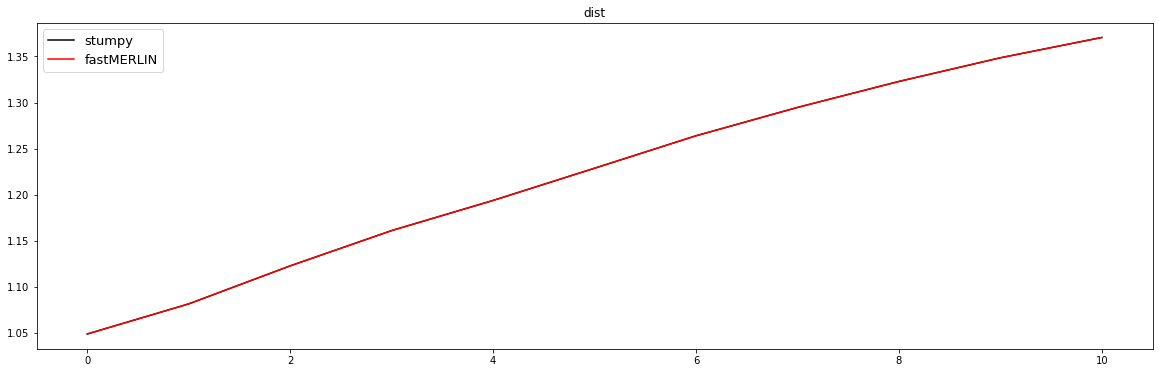

In [199]:
computation_time_dict = {}
ts_length = {}

for ts_name in ts_names_list:
    print('===================================')
    print('ts: ', ts_name)
    computation_time_list = [] #to store computation time of stumpy and fastMERLIN

    ts = ts_long[ts_name]
    ts_length[ts_name] = len(ts)
    
    minL, maxL = discord_length_choices[ts_name]
    
    #stumpy:
    print('\n> stumpy: ')
    discord_indices_MP, discord_NN_indices_MP, discord_dists_MP, time_MP = discord_finder_MP(ts, minL, maxL)
    computation_time_list.append(np.sum(time_MP))
    
    
    #fastMERLIN:
    print('\n> fastMERLN: ')
    discord_indices, discord_NN_indices, discord_dists, discord_times, discord_misses = fastMERLIN(ts, minL, maxL)
    computation_time_list.append(np.sum(discord_times))
    
    if np.sum(np.abs(discord_indices - discord_indices_MP)) != 0:
        raise ValueError("different discord indices")
        
    plt.figure()
    plt.title('dist')
    plt.plot(discord_dists_MP, c='k', label='stumpy')
    plt.plot(discord_dists, c='r', label='fastMERLIN')
    plt.legend(fontsize=13)
    plt.show()
    
    if len(np.where(np.abs(discord_dists - discord_dists_MP) > 1e-6)[0]) > 0 :
        raise ValueError("different discord dists using fastMERLIN and STUMPY")
    
    computation_time_dict[ts_name] = computation_time_list

In [200]:
#comparing perfomance of stumpy (first column) and fastMERLIN (second column) 
#... on long time series
df = pd.DataFrame(computation_time_dict)
df.index = ['stumpy', 'fastMERLIN']
df

ts_sine    ts_taxi      ts_lab
stumpy      115.016451  85.629035  285.440769
fastMERLIN   43.505672  17.071710   52.007939